# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


The objective of this project is to build a regression model that predicts a property's assessed value using its physical, location, and zoning characteristics. The goal is to identify and understand the key factors that drive property valuation, and gain more accurate decision making for personal and corporate buyers and sellers.


**1.2:**  How will your solution be used?


Our solution can be applied in a variety of ways. Real Estate investors can use the model to quickly assess whether a property's listing price is below its predicted value, helping identify potential profit opportunities. Property developers can evaluate how zoning, location, and structural decisions impact assessed value. Online real estate marketplaces, like Zillow, could integrate this model to enhance predicted property valuations like the Zestimate, improving accuracy and trust in the platform, leading to an increase of site/app users.



**1.3:**  How should success (or failure) be measured?


In a technical manner, success will be measured by the model's ability to accurately predict assessed property values, using metrics like Rsquared, RMSE, and MAE. In a real world application, the model will be considered successful if is actually leading to return on investments from  flagged underpriced properties, producting estimates that are comparable to manual appraisals, and identifying key features driving property valuation.


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [3]:
df

parcelid  airconditioningtypeid  architecturalstyletypeid  \
0      14297519                    NaN                       NaN   
1      17052889                    NaN                       NaN   
2      14186244                    NaN                       NaN   
3      12177905                    NaN                       NaN   
4      10887214                    1.0                       NaN   
...         ...                    ...                       ...   
77608  10833991                    1.0                       NaN   
77609  11000655                    NaN                       NaN   
77610  17239384                    NaN                       NaN   
77611  12773139                    1.0                       NaN   
77612  12826780                    NaN                       NaN   

       basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0               NaN          3.5         4.0                  NaN   
1               NaN          1.0         2.0                  NaN   
2               NaN          2.0         3.0                  NaN   
3               NaN          3.0         4.0                  NaN   
4               NaN          3.0         3.0                  NaN   
...             ...          ...         ...                  ...   
77608           NaN          3.0         3.0                  NaN   
77609           NaN          2.0         2.0                  NaN   
77610           NaN          2.0         4.0                  NaN   
77611           NaN          1.0         3.0                  NaN   
77612           NaN          2.0         3.0                  NaN   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
0                        NaN                3.5         NaN  ...   
1                        NaN                1.0         NaN  ...   
2                        NaN                2.0         NaN  ...   
3                        8.0                3.0         NaN  ...   
4                        8.0                3.0         NaN  ...   
...                      ...                ...         ...  ...   
77608                    8.0                3.0         NaN  ...   
77609                    6.0                2.0         NaN  ...   
77610                    NaN                2.0         NaN  ...   
77611                    4.0                1.0         NaN  ...   
77612                    6.0                2.0         NaN  ...   

       yardbuildingsqft17  yardbuildingsqft26  yearbuilt  numberofstories  \
0                     NaN                 NaN     1998.0              NaN   
1                     NaN                 NaN     1967.0              1.0   
2                     NaN                 NaN     1962.0              1.0   
3                     NaN                 NaN     1970.0              NaN   
4                     NaN                 NaN     1964.0              NaN   
...                   ...                 ...        ...              ...   
77608                 NaN                 NaN     1980.0              NaN   
77609                 NaN                 NaN     1940.0              NaN   
77610               656.0                 NaN     1964.0              1.0   
77611                 NaN                 NaN     1954.0              NaN   
77612                 NaN                 NaN     1955.0              NaN   

       fireplaceflag  assessmentyear  taxdelinquencyflag  taxdelinquencyyear  \
0                NaN          2016.0                 NaN                 NaN   
1                NaN          2016.0                 NaN                 NaN   
2                NaN          2016.0                 NaN                 NaN   
3                NaN          2016.0                 NaN                 NaN   
4                NaN          2016.0                 NaN                 NaN   
...              ...             ...                 ...                 ...   
77608            NaN          2016.0                 NaN   

In [4]:
df.head()

parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   
3  12177905                    NaN                       NaN           NaN   
4  10887214                    1.0                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          3.5         4.0                  NaN                    NaN   
1          1.0         2.0                  NaN                    NaN   
2          2.0         3.0                  NaN                    NaN   
3          3.0         4.0                  NaN                    8.0   
4          3.0         3.0                  NaN                    8.0   

   calculatedbathnbr  decktypeid  ...  yardbuildingsqft17  yardbuildingsqft26  \
0                3.5         NaN  ...                 NaN                 NaN   
1                1.0         NaN  ...                 NaN                 NaN   
2                2.0         NaN  ...                 NaN                 NaN   
3                3.0         NaN  ...                 NaN                 NaN   
4                3.0         NaN  ...                 NaN                 NaN   

   yearbuilt  numberofstories  fireplaceflag  assessmentyear  \
0     1998.0              NaN            NaN          2016.0   
1     1967.0              1.0            NaN          2016.0   
2     1962.0              1.0            NaN          2016.0   
3     1970.0              NaN            NaN          2016.0   
4     1964.0              NaN            NaN          2016.0   

   taxdelinquencyflag  taxdelinquencyyear  censustractandblock  \
0                 NaN                 NaN         6.059063e+13   
1                 NaN                 NaN         6.111001e+13   
2                 NaN                 NaN         6.059022e+13   
3                 NaN                 NaN         6.037300e+13   
4                 NaN                 NaN         6.037124e+13   

   taxvaluedollarcnt  
0          1023282.0  
1           464000.0  
2           564778.0  
3           145143.0  
4           119407.0  

[5 rows x 55 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [6]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [7]:
df.nunique().sort_values(ascending=False)

parcelid                        77414
latitude                        64038
longitude                       62461
taxvaluedollarcnt               50949
rawcensustractandblock          39188
censustractandblock             39006
lotsizesquarefeet               18848
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
propertyzoningdesc               1907
finishedsquarefeet50             1807
finishedfloor1squarefeet         1787
finishedsquarefeet15             1724
garagetotalsqft                   839
yardbuildingsqft17                540
regionidneighborhood              480
regionidzip                       389
finishedsquarefeet6               350
poolsizesum                       262
regionidcity                      175
yearbuilt                         136
propertycountylandusecode          75
yardbuildingsqft26                 59
basementsqft                       43
bathroomcnt                        22
calculatedbathnbr                  21
bedroomcnt  

In [8]:
id_columns = [col for col in df.columns if 'id' in col]
df_id_only = df[id_columns]
df_id_only

parcelid  airconditioningtypeid  architecturalstyletypeid  \
0      14297519                    NaN                       NaN   
1      17052889                    NaN                       NaN   
2      14186244                    NaN                       NaN   
3      12177905                    NaN                       NaN   
4      10887214                    1.0                       NaN   
...         ...                    ...                       ...   
77608  10833991                    1.0                       NaN   
77609  11000655                    NaN                       NaN   
77610  17239384                    NaN                       NaN   
77611  12773139                    1.0                       NaN   
77612  12826780                    NaN                       NaN   

       buildingclasstypeid  buildingqualitytypeid  decktypeid  \
0                      NaN                    NaN         NaN   
1                      NaN                    NaN         NaN   
2                      NaN                    NaN         NaN   
3                      NaN                    8.0         NaN   
4                      NaN                    8.0         NaN   
...                    ...                    ...         ...   
77608                  NaN                    8.0         NaN   
77609                  NaN                    6.0         NaN   
77610                  NaN                    NaN         NaN   
77611                  NaN                    4.0         NaN   
77612                  NaN                    6.0         NaN   

       heatingorsystemtypeid  pooltypeid10  pooltypeid2  pooltypeid7  \
0                        NaN           NaN          NaN          NaN   
1                        NaN           NaN          NaN          NaN   
2                        NaN           NaN          NaN          1.0   
3                        2.0           NaN          NaN          1.0   
4                        2.0           NaN          NaN          1.0   
...                      ...           ...          ...          ...   
77608                    2.0           NaN          NaN          1.0   
77609                    2.0           NaN          NaN          NaN   
77610                    NaN           NaN          NaN          NaN   
77611                    2.0           NaN          NaN          NaN   
77612                    2.0           NaN          NaN          NaN   

       propertylandusetypeid  regionidcity  regionidcounty  \
0                      261.0       53571.0          1286.0   
1                      261.0       13091.0          2061.0   
2                      261.0       21412.0          1286.0   
3                      261.0      396551.0          3101.0   
4                      266.0       12447.0          3101.0   
...                      ...           ...             ...   
77608                  266.0       12447.0          3101.0   
77609                  261.0       12447.0          3101.0   
77610                  261.0       27110.0          2061.0   
77611                  261.0       36502.0          3101.0   
77612                  261.0       14634.0          3101.0   

       regionidneighborhood  regionidzip  storytypeid  typeconstructiontypeid  
0                       NaN      96978.0          NaN                     NaN  
1                       NaN      97099.0          NaN                     NaN  
2                       NaN      97078.0          NaN                     NaN  
3                       NaN      96330.0          NaN                     NaN  
4                  268548.0      96451.0          NaN                     NaN  
...                     ...          ...          ...                     ...  
77608               32368.0      96415.0          NaN                     NaN  
77609               27328.0      96284.0          NaN                     NaN  
77610                   NaN      97116.0          NaN                     NaN  

In [9]:
for col in id_columns:
    print(f"Unique values in column '{col}':")
    print(df[col].unique())
    print("-" * 40) 


Unique values in column 'parcelid':
[14297519 17052889 14186244 ... 17239384 12773139 12826780]
----------------------------------------
Unique values in column 'airconditioningtypeid':
[nan  1. 13.  5. 11.  9.]
----------------------------------------
Unique values in column 'architecturalstyletypeid':
[nan  7.  8. 21.  3.  2.]
----------------------------------------
Unique values in column 'buildingclasstypeid':
[nan  4.  3.]
----------------------------------------
Unique values in column 'buildingqualitytypeid':
[nan  8.  9.  5.  4.  6.  7. 10.  3. 11. 12.  1.  2.]
----------------------------------------
Unique values in column 'decktypeid':
[nan 66.]
----------------------------------------
Unique values in column 'heatingorsystemtypeid':
[nan  2.  7.  6. 24. 13. 18. 20.  1. 10. 11.]
----------------------------------------
Unique values in column 'pooltypeid10':
[nan  1.]
----------------------------------------
Unique values in column 'pooltypeid2':
[nan  1.]
-----------------

In [10]:
pool_columns = [col for col in df.columns if 'pool' in col]
df_pool_only = df[pool_columns]
df_pool_only


poolcnt  poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7
0          NaN          NaN           NaN          NaN          NaN
1          NaN          NaN           NaN          NaN          NaN
2          1.0          NaN           NaN          NaN          1.0
3          1.0          NaN           NaN          NaN          1.0
4          1.0          NaN           NaN          NaN          1.0
...        ...          ...           ...          ...          ...
77608      1.0          NaN           NaN          NaN          1.0
77609      NaN          NaN           NaN          NaN          NaN
77610      NaN          NaN           NaN          NaN          NaN
77611      NaN          NaN           NaN          NaN          NaN
77612      NaN          NaN           NaN          NaN          NaN

[77613 rows x 5 columns]

In [11]:
df_pool_only.groupby('poolcnt').nunique()

poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7
poolcnt                                                     
1.0              262             0            1            1

In [12]:
df[['pooltypeid2','pooltypeid10']].groupby('pooltypeid10').nunique()

pooltypeid2
pooltypeid10             
1.0                     0

In [13]:
df[df['pooltypeid2']!=df['pooltypeid10']]

parcelid  airconditioningtypeid  architecturalstyletypeid  \
0      14297519                    NaN                       NaN   
1      17052889                    NaN                       NaN   
2      14186244                    NaN                       NaN   
3      12177905                    NaN                       NaN   
4      10887214                    1.0                       NaN   
...         ...                    ...                       ...   
77608  10833991                    1.0                       NaN   
77609  11000655                    NaN                       NaN   
77610  17239384                    NaN                       NaN   
77611  12773139                    1.0                       NaN   
77612  12826780                    NaN                       NaN   

       basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0               NaN          3.5         4.0                  NaN   
1               NaN          1.0         2.0                  NaN   
2               NaN          2.0         3.0                  NaN   
3               NaN          3.0         4.0                  NaN   
4               NaN          3.0         3.0                  NaN   
...             ...          ...         ...                  ...   
77608           NaN          3.0         3.0                  NaN   
77609           NaN          2.0         2.0                  NaN   
77610           NaN          2.0         4.0                  NaN   
77611           NaN          1.0         3.0                  NaN   
77612           NaN          2.0         3.0                  NaN   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
0                        NaN                3.5         NaN  ...   
1                        NaN                1.0         NaN  ...   
2                        NaN                2.0         NaN  ...   
3                        8.0                3.0         NaN  ...   
4                        8.0                3.0         NaN  ...   
...                      ...                ...         ...  ...   
77608                    8.0                3.0         NaN  ...   
77609                    6.0                2.0         NaN  ...   
77610                    NaN                2.0         NaN  ...   
77611                    4.0                1.0         NaN  ...   
77612                    6.0                2.0         NaN  ...   

       yardbuildingsqft17  yardbuildingsqft26  yearbuilt  numberofstories  \
0                     NaN                 NaN     1998.0              NaN   
1                     NaN                 NaN     1967.0              1.0   
2                     NaN                 NaN     1962.0              1.0   
3                     NaN                 NaN     1970.0              NaN   
4                     NaN                 NaN     1964.0              NaN   
...                   ...                 ...        ...              ...   
77608                 NaN                 NaN     1980.0              NaN   
77609                 NaN                 NaN     1940.0              NaN   
77610               656.0                 NaN     1964.0              1.0   
77611                 NaN                 NaN     1954.0              NaN   
77612                 NaN                 NaN     1955.0              NaN   

       fireplaceflag  assessmentyear  taxdelinquencyflag  taxdelinquencyyear  \
0                NaN          2016.0                 NaN                 NaN   
1                NaN          2016.0                 NaN                 NaN   
2                NaN          2016.0                 NaN                 NaN   
3                NaN          2016.0                 NaN                 NaN   
4                NaN          2016.0                 NaN                 NaN   
...              ...             ...                 ...                 ...   
77608            NaN          2016.0                 NaN   

In [14]:
df['fireplacecnt'].value_counts()


fireplacecnt
1.0    7018
2.0     998
3.0     235
4.0      35
5.0       3
Name: count, dtype: int64

In [15]:
df[['fireplacecnt','fireplaceflag']].groupby('fireplaceflag').value_counts()

Series([], Name: count, dtype: int64)

In [16]:
df[df['fireplaceflag']==True][['fireplacecnt','fireplaceflag']]

fireplacecnt fireplaceflag
125             NaN          True
206             NaN          True
627             NaN          True
844             NaN          True
850             NaN          True
...             ...           ...
74643           NaN          True
75783           NaN          True
76089           NaN          True
76411           NaN          True
76703           NaN          True

[172 rows x 2 columns]

In [17]:
df['censustractandblock'].value_counts().sort_values(ascending=False).head(20)

censustractandblock
6.037137e+13    60
6.037277e+13    51
6.059032e+13    44
6.037920e+13    41
6.059063e+13    41
6.037920e+13    40
6.059063e+13    40
6.037139e+13    40
6.037577e+13    39
6.037578e+13    38
6.037920e+13    37
6.059052e+13    34
6.037296e+13    31
6.037920e+13    30
6.111007e+13    30
6.037208e+13    30
6.059052e+13    29
6.037576e+13    29
6.037300e+13    29
6.059052e+13    28
Name: count, dtype: int64

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [18]:
df_obj = df.select_dtypes(include=object)
df_obj

hashottuborspa propertycountylandusecode propertyzoningdesc  \
0                NaN                       122                NaN   
1                NaN                      1110                NaN   
2                NaN                       122                NaN   
3                NaN                      0101         LCR110000*   
4                NaN                      010C               LAR3   
...              ...                       ...                ...   
77608            NaN                      010C              LARD3   
77609            NaN                      0100             LARE40   
77610            NaN                      1111                NaN   
77611            NaN                      0100              SER1*   
77612            NaN                      0100          WHR16000*   

      fireplaceflag taxdelinquencyflag  
0               NaN                NaN  
1               NaN                NaN  
2               NaN                NaN  
3               NaN                NaN  
4               NaN                NaN  
...             ...                ...  
77608           NaN                NaN  
77609           NaN                NaN  
77610           NaN                NaN  
77611           NaN                NaN  
77612           NaN                NaN  

[77613 rows x 5 columns]

In [19]:
df_obj.nunique()

hashottuborspa                  1
propertycountylandusecode      75
propertyzoningdesc           1907
fireplaceflag                   1
taxdelinquencyflag              1
dtype: int64

In [20]:
print("hashottuborspa unique values: ",df_obj['hashottuborspa'].unique())
print("fireplaceflag unique values: ",df_obj['fireplaceflag'].unique())
print("taxdelinquencyflag unique values: ",df_obj['taxdelinquencyflag'].unique())


hashottuborspa unique values:  [nan True]
fireplaceflag unique values:  [nan True]
taxdelinquencyflag unique values:  [nan 'Y']


There are 5 categorical features in this dataset:

1. hashottuborspa: indicator if the property has a hashottuborspa. All values are either True or Null.

2. propertycountylandusecode: an identifier for the land use code, often used for tax purposes

3. propertyzoningdesc: zoning code for the property 

4. fireplaceflag: A feature indicating if the property has a fireplace. All values are either True or Null.

5. taxdelinquencyflag: A feature indicating if the property has taxes that are past due. All values are either "Y" or Null.


hashottuborspa, fireplaceflag, and taxdelinquencyflag could be encoded so that Yes/True values are 1 and null values are 0.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

In [21]:
df

parcelid  airconditioningtypeid  architecturalstyletypeid  \
0      14297519                    NaN                       NaN   
1      17052889                    NaN                       NaN   
2      14186244                    NaN                       NaN   
3      12177905                    NaN                       NaN   
4      10887214                    1.0                       NaN   
...         ...                    ...                       ...   
77608  10833991                    1.0                       NaN   
77609  11000655                    NaN                       NaN   
77610  17239384                    NaN                       NaN   
77611  12773139                    1.0                       NaN   
77612  12826780                    NaN                       NaN   

       basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0               NaN          3.5         4.0                  NaN   
1               NaN          1.0         2.0                  NaN   
2               NaN          2.0         3.0                  NaN   
3               NaN          3.0         4.0                  NaN   
4               NaN          3.0         3.0                  NaN   
...             ...          ...         ...                  ...   
77608           NaN          3.0         3.0                  NaN   
77609           NaN          2.0         2.0                  NaN   
77610           NaN          2.0         4.0                  NaN   
77611           NaN          1.0         3.0                  NaN   
77612           NaN          2.0         3.0                  NaN   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
0                        NaN                3.5         NaN  ...   
1                        NaN                1.0         NaN  ...   
2                        NaN                2.0         NaN  ...   
3                        8.0                3.0         NaN  ...   
4                        8.0                3.0         NaN  ...   
...                      ...                ...         ...  ...   
77608                    8.0                3.0         NaN  ...   
77609                    6.0                2.0         NaN  ...   
77610                    NaN                2.0         NaN  ...   
77611                    4.0                1.0         NaN  ...   
77612                    6.0                2.0         NaN  ...   

       yardbuildingsqft17  yardbuildingsqft26  yearbuilt  numberofstories  \
0                     NaN                 NaN     1998.0              NaN   
1                     NaN                 NaN     1967.0              1.0   
2                     NaN                 NaN     1962.0              1.0   
3                     NaN                 NaN     1970.0              NaN   
4                     NaN                 NaN     1964.0              NaN   
...                   ...                 ...        ...              ...   
77608                 NaN                 NaN     1980.0              NaN   
77609                 NaN                 NaN     1940.0              NaN   
77610               656.0                 NaN     1964.0              1.0   
77611                 NaN                 NaN     1954.0              NaN   
77612                 NaN                 NaN     1955.0              NaN   

       fireplaceflag  assessmentyear  taxdelinquencyflag  taxdelinquencyyear  \
0                NaN          2016.0                 NaN                 NaN   
1                NaN          2016.0                 NaN                 NaN   
2                NaN          2016.0                 NaN                 NaN   
3                NaN          2016.0                 NaN                 NaN   
4                NaN          2016.0                 NaN                 NaN   
...              ...             ...                 ...                 ...   
77608            NaN          2016.0                 NaN   

In [22]:
df.shape

(77613, 55)

In [23]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [24]:
df['parcelid'].value_counts()

parcelid
11991059    3
10857130    3
12612211    3
12955531    2
14008322    2
           ..
17128107    1
11933583    1
11249343    1
12321401    1
12388060    1
Name: count, Length: 77414, dtype: int64

In [25]:
df[df['parcelid'].duplicated()].sort_values(by='parcelid', ascending=False)
# .groupby('parcelid').nunique()

parcelid  airconditioningtypeid  architecturalstyletypeid  \
34299  162960529                    NaN                       NaN   
4530    17295416                    NaN                       NaN   
64278   17282392                    NaN                       NaN   
38851   17280166                    NaN                       NaN   
29466   17251843                    NaN                       NaN   
...          ...                    ...                       ...   
3540    10753427                    1.0                       NaN   
28611   10744507                    NaN                       NaN   
2905    10739478                    1.0                       NaN   
13914   10732347                    NaN                       NaN   
14034   10722858                    NaN                       NaN   

       basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
34299           NaN          4.0         4.0                  NaN   
4530            NaN          2.0         2.0                  NaN   
64278           NaN          2.0         3.0                  NaN   
38851           NaN          3.0         4.0                  NaN   
29466           NaN          2.0         2.0                  NaN   
...             ...          ...         ...                  ...   
3540            NaN          2.0         2.0                  NaN   
28611           NaN          3.0         4.0                  NaN   
2905            NaN          3.0         4.0                  NaN   
13914           NaN          2.0         4.0                  NaN   
14034           NaN          2.0         4.0                  NaN   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
34299                    NaN                4.0         NaN  ...   
4530                     NaN                2.0         NaN  ...   
64278                    NaN                2.0         NaN  ...   
38851                    NaN                3.0         NaN  ...   
29466                    NaN                2.0         NaN  ...   
...                      ...                ...         ...  ...   
3540                     7.0                2.0         NaN  ...   
28611                    8.0                3.0         NaN  ...   
2905                     8.0                3.0         NaN  ...   
13914                    8.0                2.0         NaN  ...   
14034                    6.0                2.0         NaN  ...   

       yardbuildingsqft17  yardbuildingsqft26  yearbuilt  numberofstories  \
34299                 NaN                 NaN     2007.0              2.0   
4530                 98.0                 NaN     1973.0              1.0   
64278              1054.0                 NaN     1963.0              1.0   
38851               140.0                 NaN     1960.0              1.0   
29466               102.0                 NaN     1984.0              1.0   
...                   ...                 ...        ...              ...   
3540                  NaN                 NaN     1972.0              NaN   
28611                 NaN                 NaN     1978.0              NaN   
2905                  NaN                 NaN     1965.0              NaN   
13914                 NaN                 NaN     1960.0              NaN   
14034                 NaN                 NaN     1960.0              NaN   

       fireplaceflag  assessmentyear  taxdelinquencyflag  taxdelinquencyyear  \
34299            NaN          2016.0                 NaN                 NaN   
4530             NaN          2016.0                 NaN                 NaN   
64278            NaN          2016.0                 NaN                 NaN   
38851            NaN          2016.0                 NaN                 NaN   
29466            NaN          2016.0                 NaN                 NaN   
...              ...             ...                 ...                 ...   
3540             NaN          2016.0            

In [26]:
df[df['parcelid']==11991059]

parcelid  airconditioningtypeid  architecturalstyletypeid  \
43840  11991059                    NaN                       NaN   
43841  11991059                    NaN                       NaN   
43842  11991059                    NaN                       NaN   

       basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
43840           NaN          6.0        12.0                  NaN   
43841           NaN          6.0        12.0                  NaN   
43842           NaN          6.0        12.0                  NaN   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
43840                    5.0                6.0         NaN  ...   
43841                    5.0                6.0         NaN  ...   
43842                    5.0                6.0         NaN  ...   

       yardbuildingsqft17  yardbuildingsqft26  yearbuilt  numberofstories  \
43840                 NaN                 NaN     1909.0              NaN   
43841                 NaN                 NaN     1909.0              NaN   
43842                 NaN                 NaN     1909.0              NaN   

       fireplaceflag  assessmentyear  taxdelinquencyflag  taxdelinquencyyear  \
43840            NaN          2016.0                 NaN                 NaN   
43841            NaN          2016.0                 NaN                 NaN   
43842            NaN          2016.0                 NaN                 NaN   

       censustractandblock  taxvaluedollarcnt  
43840                  NaN          2485282.0  
43841                  NaN          2485282.0  
43842                  NaN          2485282.0  

[3 rows x 55 columns]

In [27]:
df[['censustractandblock', 'rawcensustractandblock']]

censustractandblock  rawcensustractandblock
0             6.059063e+13            6.059063e+07
1             6.111001e+13            6.111001e+07
2             6.059022e+13            6.059022e+07
3             6.037300e+13            6.037300e+07
4             6.037124e+13            6.037124e+07
...                    ...                     ...
77608         6.037132e+13            6.037132e+07
77609         6.037101e+13            6.037101e+07
77610         6.111008e+13            6.111008e+07
77611         6.037434e+13            6.037434e+07
77612         6.037503e+13            6.037503e+07

[77613 rows x 2 columns]

In [28]:
df[['regionidcounty', 'fips']].groupby('regionidcounty').nunique()

fips
regionidcounty      
1286.0             1
2061.0             1
3101.0             1

In [29]:
df[['hashottuborspa', 'pooltypeid10']].groupby('hashottuborspa').nunique()

pooltypeid10
hashottuborspa              
True                       1

There are multiple features that appear to be useless for the purpose of this project:
1. parcelid is a unique identifier assigned to each property. A unique ID for each property would not be helpful in predicting property prices. Duplicate parcelids seem to be duplicate entries of the a property.
2. rawcensustractandblock is the uncleaned version of censustractandblock, and likely not useful for any analysis.
3. fips is an identifier for county, which is also what regionidcounty is used for. All properties with the same fips code have the same regionidcounty code. 
4. Both hashottuborspa and pooltypeid10 indicate if the property has a hot tub or a spa.



**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

In [30]:
##From Homework 4

def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']}")



In [31]:
show_null_counts_features(df)

The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
buildingclasstypeid 77598        99.98%   Numeric
finishedsquarefeet13 77571        99.95%   Numeric
basementsqft    77563        99.94%   Numeric
storytypeid     77563        99.94%   Numeric
yardbuildingsqft26 77543        99.91%   Numeric
fireplaceflag   77441        99.78%   Categorical
architecturalstyletypeid 77406        99.73%   Numeric
typeconstructiontypeid 77390        99.71%   Numeric
finishedsquarefeet6 77227        99.50%   Numeric
pooltypeid10    77148        99.40%   Numeric
decktypeid      76999        99.21%   Numeric
poolsizesum     76744        98.88%   Numeric
pooltypeid2     76539        98.62%   Numeric
hashottuborspa  76074        98.02%   Categorical
yardbuildingsqft17 75220        96.92%   Numeric
taxdelinquencyflag 74713        96.26%   Categorical
taxdelinquencyyear 74713        96.26%   Numeric
finishedsquarefeet15 74586        96.10%

In [32]:
df_temp = df.copy()
missing_df = df_temp.isna().sum().sort_values(ascending=False).reset_index()
missing_df.columns = ['column', 'num_missing']
missing_df['Percentage of Missing Values'] = (missing_df['num_missing'] / df_temp.shape[0]) * 100
missing_df.sort_values(by='Percentage of Missing Values', ascending=False, inplace=True)
columns_missingover90 = missing_df[missing_df['Percentage of Missing Values'] > 90]['column'].tolist()
df[columns_missingover90].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   buildingclasstypeid       15 non-null     float64
 1   finishedsquarefeet13      42 non-null     float64
 2   basementsqft              50 non-null     float64
 3   storytypeid               50 non-null     float64
 4   yardbuildingsqft26        70 non-null     float64
 5   fireplaceflag             172 non-null    object 
 6   architecturalstyletypeid  207 non-null    float64
 7   typeconstructiontypeid    223 non-null    float64
 8   finishedsquarefeet6       386 non-null    float64
 9   pooltypeid10              465 non-null    float64
 10  decktypeid                614 non-null    float64
 11  poolsizesum               869 non-null    float64
 12  pooltypeid2               1074 non-null   float64
 13  hashottuborspa            1539 non-null   object 
 14  yardbu

In [33]:
df_temp = df.copy()
missing_df = df_temp.isna().sum().sort_values(ascending=False).reset_index()
missing_df.columns = ['column', 'num_missing']
missing_df['Percentage of Missing Values'] = (missing_df['num_missing'] / df_temp.shape[0]) * 100
missing_df.sort_values(by='Percentage of Missing Values', ascending=False, inplace=True)
columns_missingover99 = missing_df[missing_df['Percentage of Missing Values'] > 99]['column'].tolist()
df[columns_missingover99].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   buildingclasstypeid       15 non-null     float64
 1   finishedsquarefeet13      42 non-null     float64
 2   basementsqft              50 non-null     float64
 3   storytypeid               50 non-null     float64
 4   yardbuildingsqft26        70 non-null     float64
 5   fireplaceflag             172 non-null    object 
 6   architecturalstyletypeid  207 non-null    float64
 7   typeconstructiontypeid    223 non-null    float64
 8   finishedsquarefeet6       386 non-null    float64
 9   pooltypeid10              465 non-null    float64
 10  decktypeid                614 non-null    float64
dtypes: float64(10), object(1)
memory usage: 6.5+ MB


Yes, there are multiple features that have a high percentage of missing values. There are 20 features with over 90% missing values:

1.  buildingclasstypeid  
2.  finishedsquarefeet13  
3.  storytypeid  
4.  basementsqft  
5.  yardbuildingsqft26  
6.  fireplaceflag  
7.  architecturalstyletypeid  
8.  typeconstructiontypeid  
9.  finishedsquarefeet6  
10. pooltypeid10  
11. decktypeid  
12. poolsizesum  
13. pooltypeid2  
14. hashottuborspa  
15. yardbuildingsqft17  
16. taxdelinquencyflag  
17. taxdelinquencyyear  
18. finishedsquarefeet15  
19. finishedsquarefeet50  
20. finishedfloor1squarefeet 

Of these, there are 11 features with over 99% of the values missing:
1.  buildingclasstypeid  
2.  finishedsquarefeet13  
3.  storytypeid  
4.  basementsqft  
5.  yardbuildingsqft26  
6.  fireplaceflag  
7.  architecturalstyletypeid  
8.  typeconstructiontypeid  
9.  finishedsquarefeet6  
10. pooltypeid10  
11. decktypeid  

Features like buildingclasstypeid, architecturalstyletypeid and typeconstructiontypeid seem like they would be useful for this project as they are identifiers for the style, type, and quality of build of a property, however, with almost all values being null, these features seem useless.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

In [34]:
df.nunique().sort_values(ascending=True)

decktypeid                          1
pooltypeid7                         1
pooltypeid2                         1
pooltypeid10                        1
poolcnt                             1
hashottuborspa                      1
taxdelinquencyflag                  1
storytypeid                         1
fireplaceflag                       1
assessmentyear                      1
buildingclasstypeid                 2
regionidcounty                      3
fips                                3
typeconstructiontypeid              4
numberofstories                     4
threequarterbathnbr                 4
architecturalstyletypeid            5
fireplacecnt                        5
airconditioningtypeid               5
unitcnt                             8
heatingorsystemtypeid              10
buildingqualitytypeid              12
propertylandusetypeid              13
taxdelinquencyyear                 13
fullbathcnt                        13
finishedsquarefeet13               13
garagecarcnt

In [35]:
df.nunique().sort_values(ascending=False)

parcelid                        77414
latitude                        64038
longitude                       62461
taxvaluedollarcnt               50949
rawcensustractandblock          39188
censustractandblock             39006
lotsizesquarefeet               18848
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
propertyzoningdesc               1907
finishedsquarefeet50             1807
finishedfloor1squarefeet         1787
finishedsquarefeet15             1724
garagetotalsqft                   839
yardbuildingsqft17                540
regionidneighborhood              480
regionidzip                       389
finishedsquarefeet6               350
poolsizesum                       262
regionidcity                      175
yearbuilt                         136
propertycountylandusecode          75
yardbuildingsqft26                 59
basementsqft                       43
bathroomcnt                        22
calculatedbathnbr                  21
bedroomcnt  

There are some features with a small number of unique values that could be useless:
1. assessmentyear only has one value, 2016, which would not be helpful for the analysis
2. decktypeid is an identifier for type of deck on the property, but only has one value
3. poolcnt is a count for number of pools on the property, but only a count of one or null (assumed to be properties with no pools)

There are also some values with a high amount of unique values that could possibly cause high cardinaility:
1. Latitutde and Longitude
2. censustractandblock 


### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

<Figure size 2000x2500 with 0 Axes>

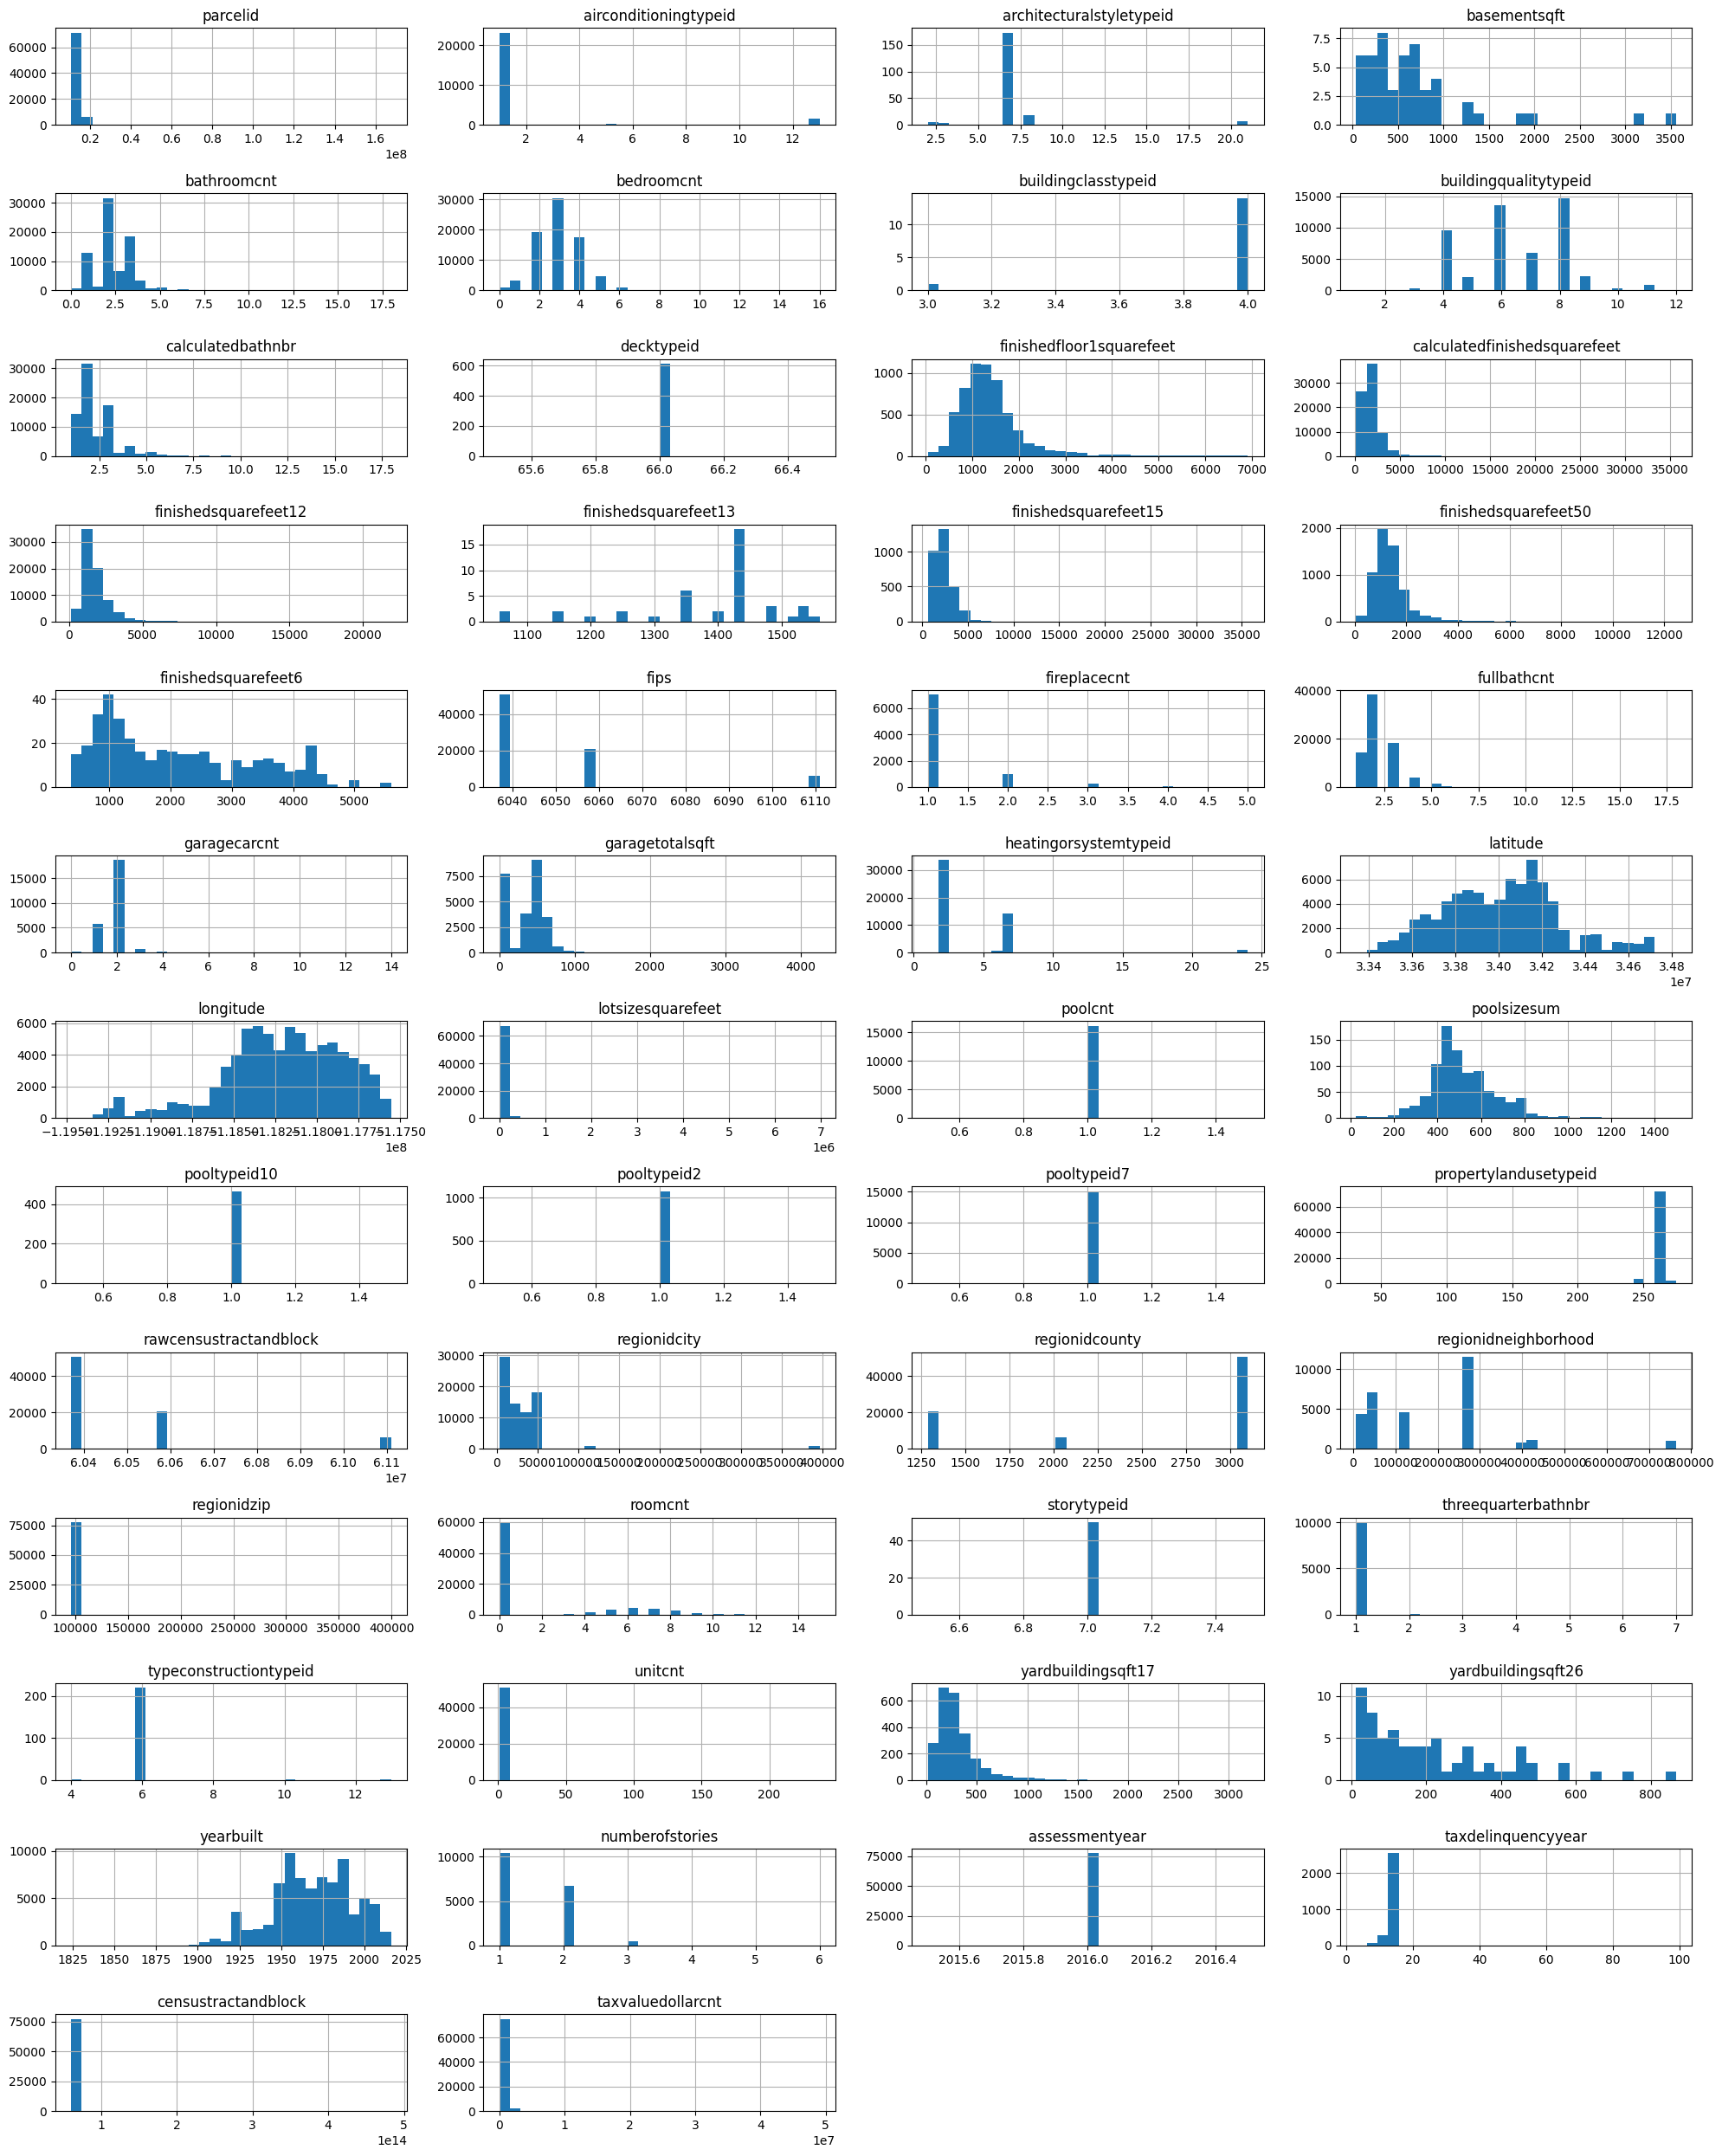

In [36]:
plt.figure(figsize=(20, 25))
df.hist(figsize=(20, 25), bins=30, layout=(-1, 4))  
plt.tight_layout()
plt.show()

1. Target Variable - taxvaluedollarcnt

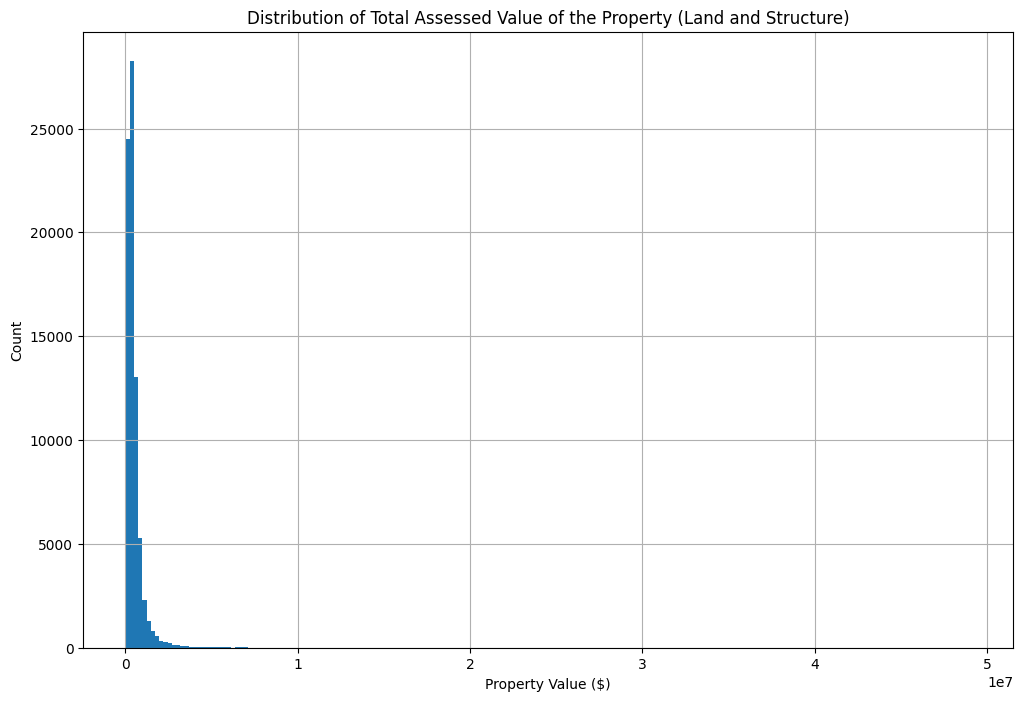

In [37]:
##Creating a histogram of the target variable
plt.figure(figsize=(12, 8))
df['taxvaluedollarcnt'].hist(bins=200)
plt.title('Distribution of Total Assessed Value of the Property (Land and Structure)')
plt.xlabel('Property Value ($)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

It seems that there are some outliers in the target variable. It is currently right skewed with most values concentrated under 1,000,000 dollars in property value.

In [38]:
df['taxvaluedollarcnt'].describe()

count    7.757800e+04
mean     4.901506e+05
std      6.537979e+05
min      1.000000e+03
25%      2.068985e+05
50%      3.588785e+05
75%      5.690000e+05
max      4.906124e+07
Name: taxvaluedollarcnt, dtype: float64

The max property in the dataset is about 49 million. A scatterplot will be created to show the outliers

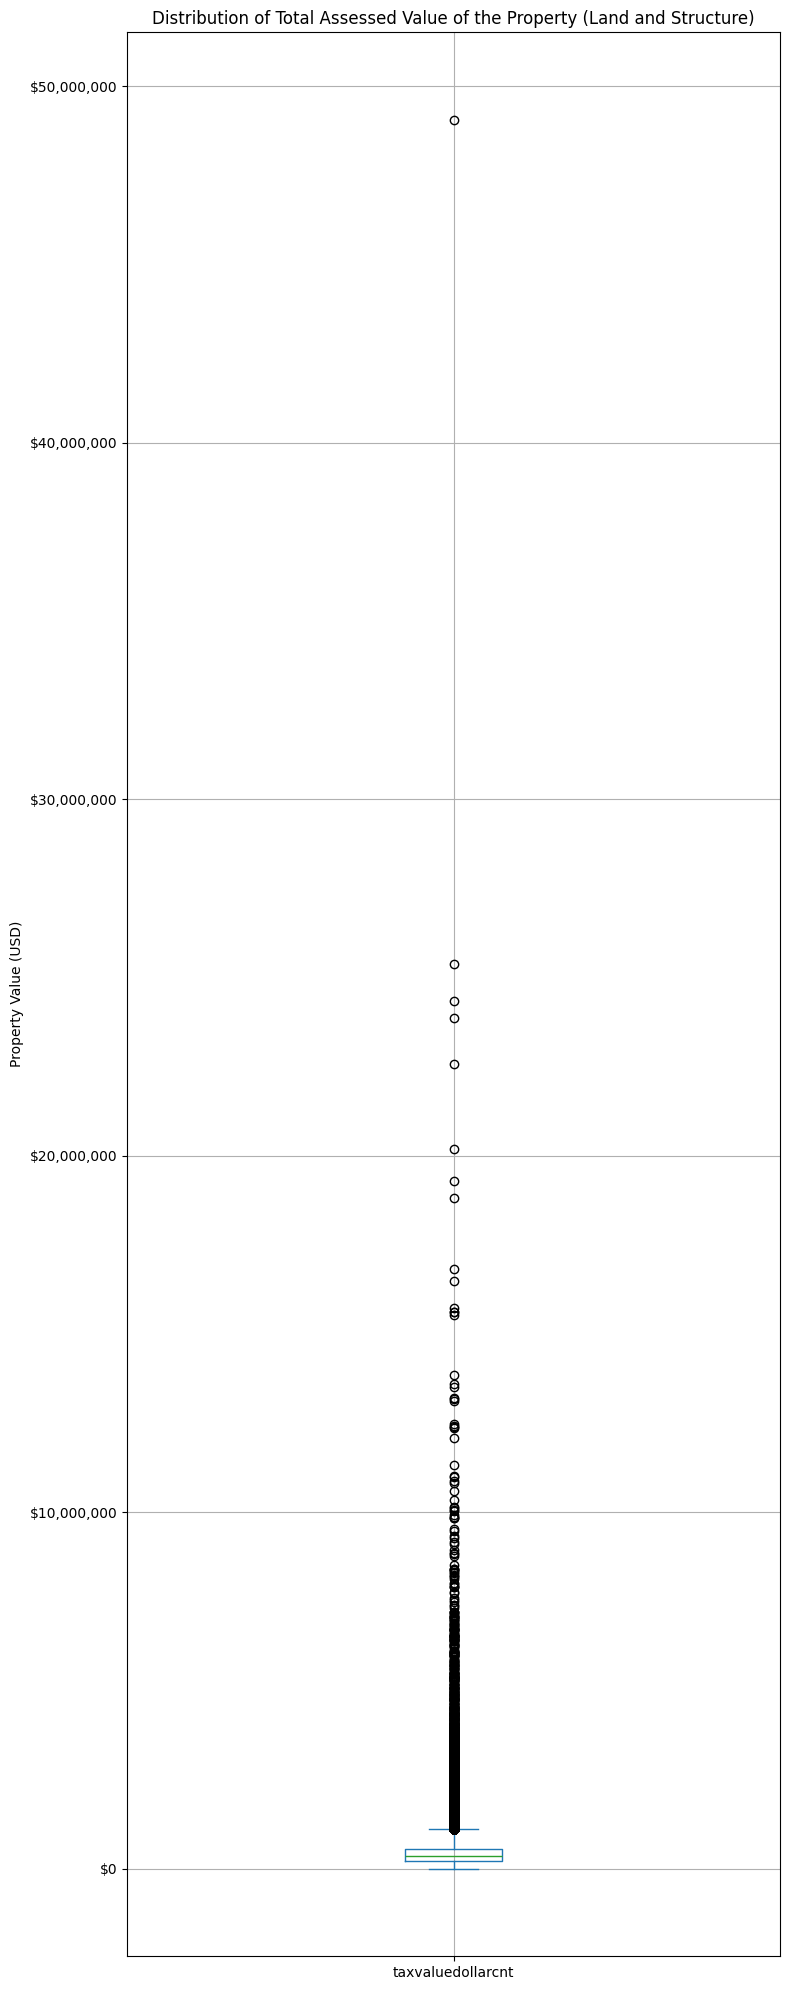

In [39]:
plt.figure(figsize=(8, 20))
ax = df['taxvaluedollarcnt'].plot.box()
plt.title('Distribution of Total Assessed Value of the Property (Land and Structure)')
plt.ylabel('Property Value (USD)')
formatter = mticker.FuncFormatter(lambda x, _: f'${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.tight_layout()
plt.show()

/root/venv/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


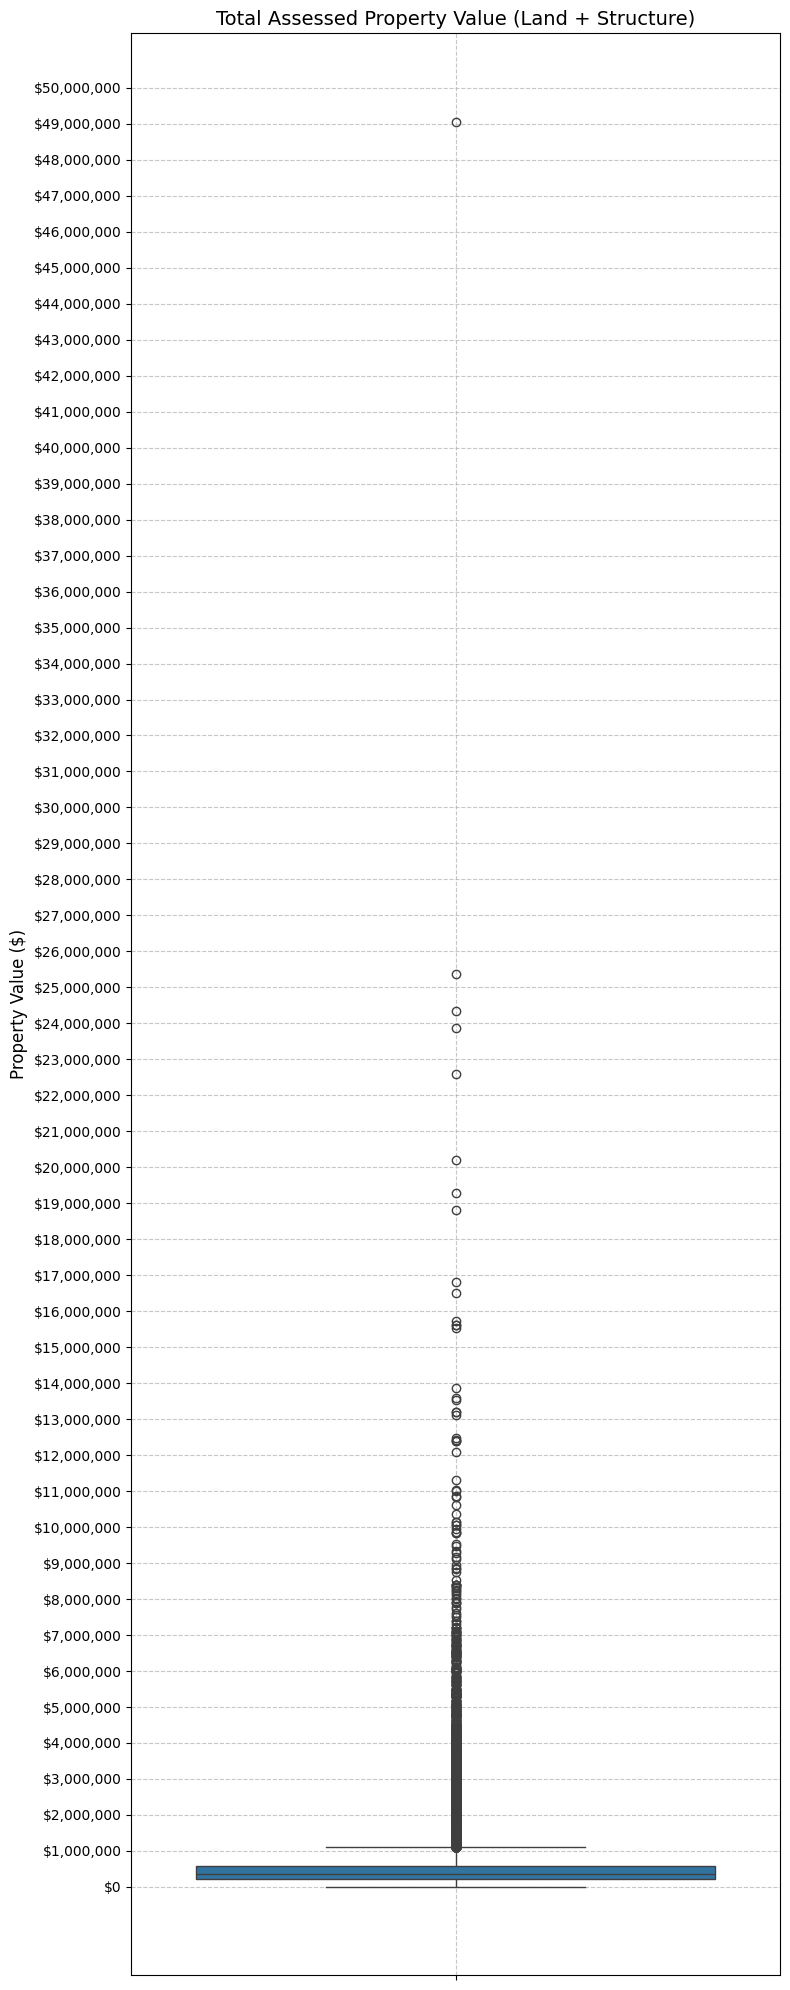

In [40]:
#Creating a boxplot of the target variable to see the outliers
fig, ax = plt.subplots(figsize=(8, 20))
sns.boxplot(y=df['taxvaluedollarcnt'], ax=ax)
ax.set_title('Total Assessed Property Value (Land + Structure)', fontsize=14)
ax.set_ylabel('Property Value ($)', fontsize=12)
max_value = 50000000
ticks = np.arange(0, max_value + 1000000, 1000000)
ax.set_yticks(ticks)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Looking at the boxplot, most of the property values are between 0 and 1,000,000 dollars. Any property that is slightly above 1,100,000 dollars is an outlier.

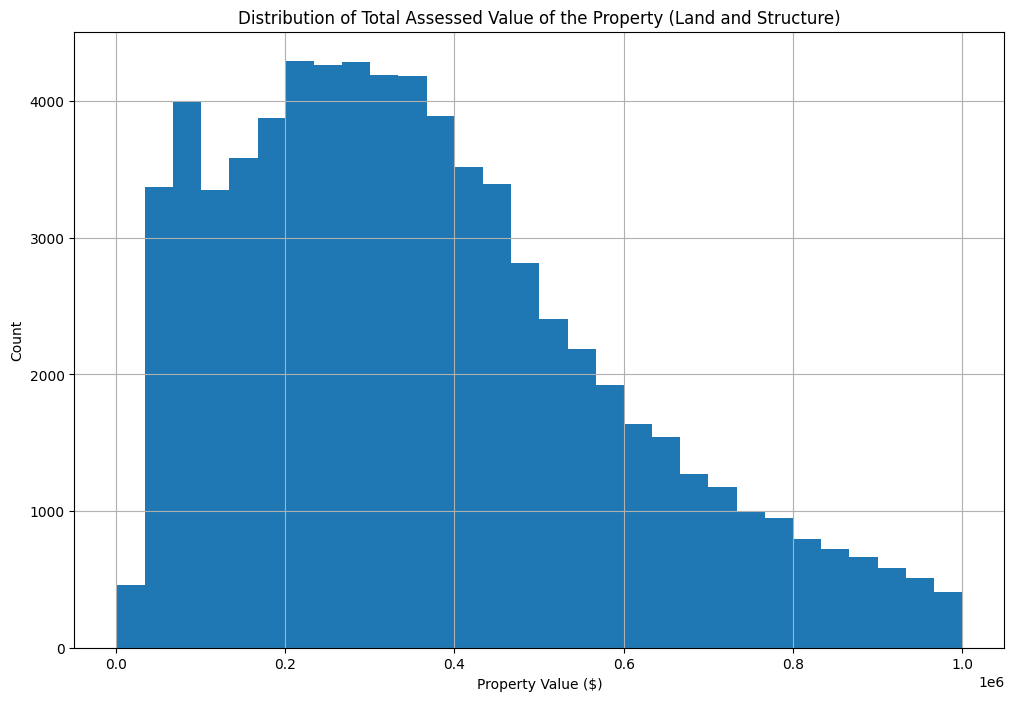

In [41]:
under_1m_df = df[df['taxvaluedollarcnt'] < 1000000]
plt.figure(figsize=(12, 8))
under_1m_df['taxvaluedollarcnt'].hist(bins=30)
plt.title('Distribution of Total Assessed Value of the Property (Land and Structure)')
plt.xlabel('Property Value ($)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Only looking at properties under 1,000,000 dollars, has a distribution that is closer to normal, with a still a right skew.

2. Year Built

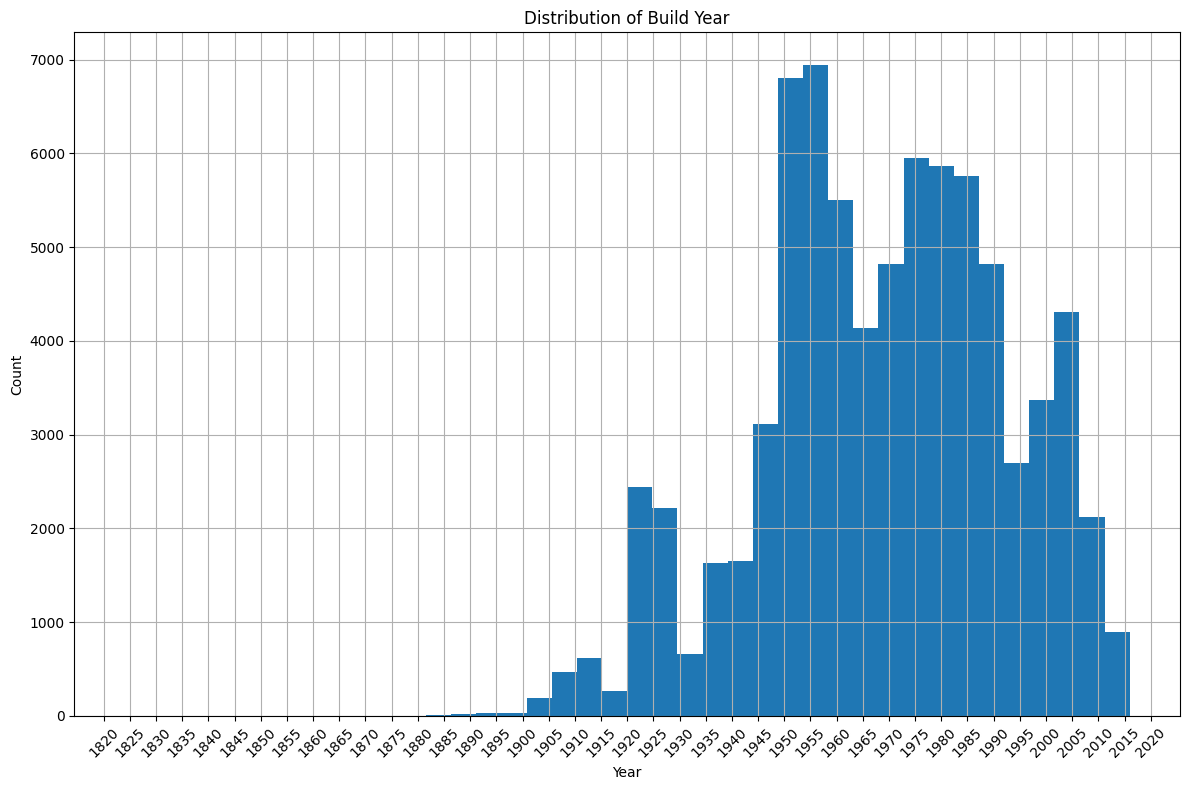

In [42]:
##Creating a histogram of the year built

min_year = int(df['yearbuilt'].min() // 5 * 5)
max_year = int(df['yearbuilt'].max() // 5 * 5 + 5)
year_ticks = np.arange(min_year, max_year + 1, 5)
plt.figure(figsize=(12, 8))
df['yearbuilt'].hist(bins=40)
plt.title('Distribution of Build Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(year_ticks, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The build year distribution has a large left skew. A boxplot will be created to show the outliers

/root/venv/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


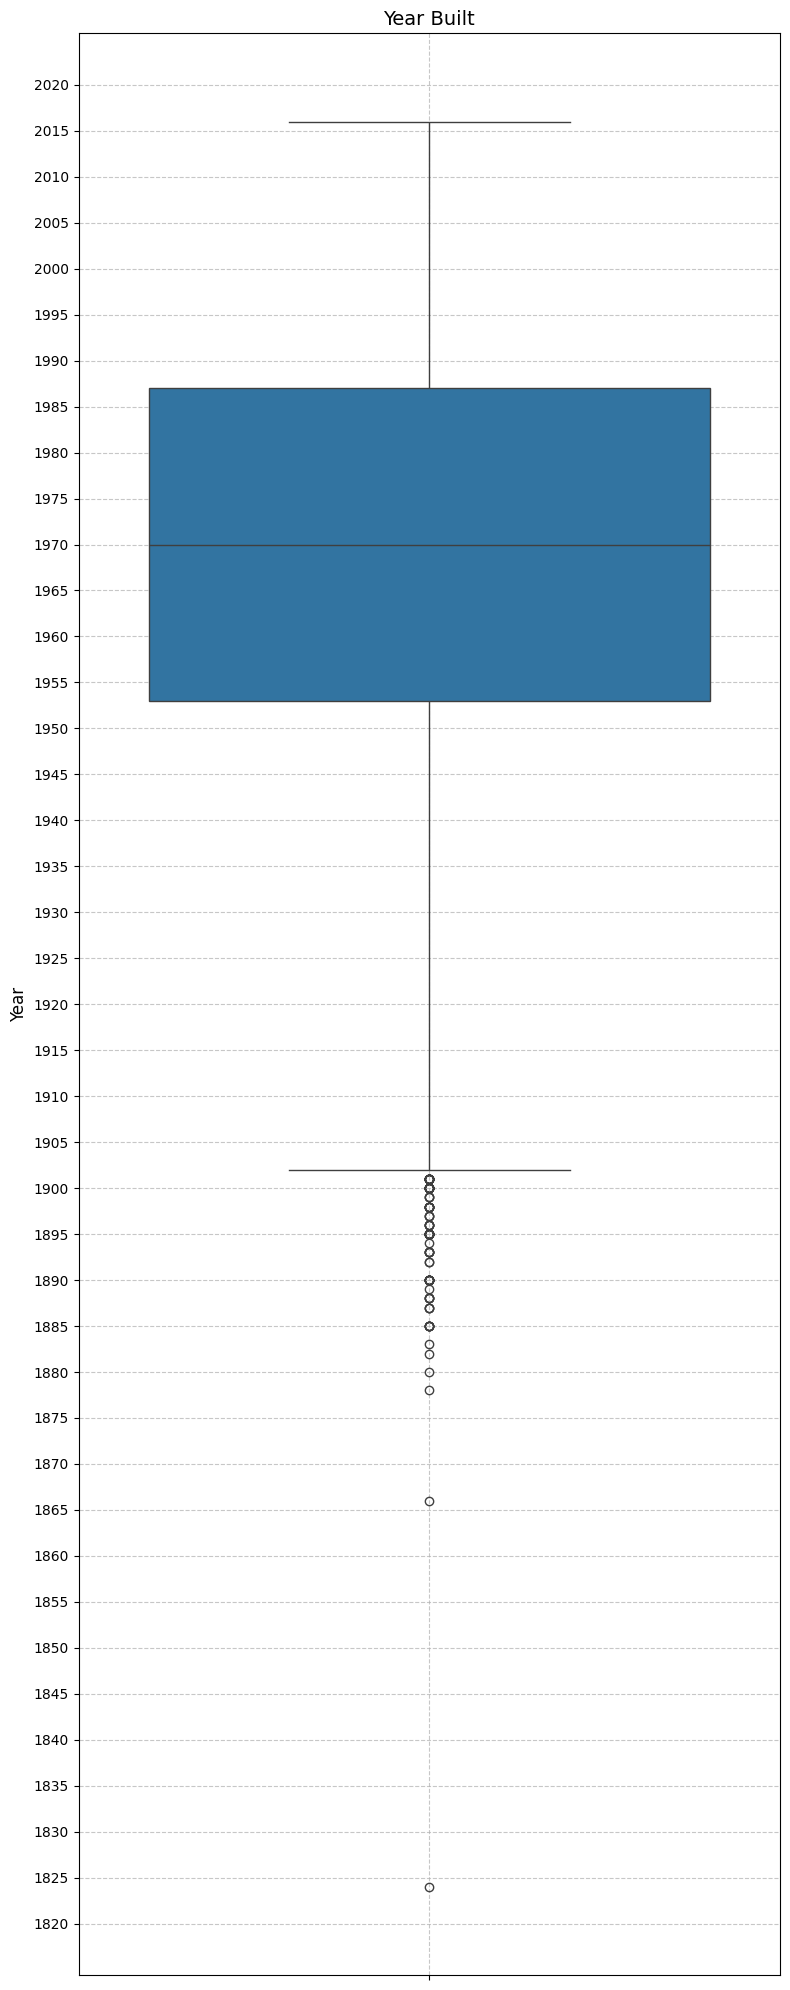

In [43]:
min_year = int(df['yearbuilt'].min() // 5 * 5)
max_year = int(df['yearbuilt'].max() // 5 * 5 + 5)
year_ticks = np.arange(min_year, max_year + 1, 5)
fig, ax = plt.subplots(figsize=(8, 20))
sns.boxplot(y=df['yearbuilt'], ax=ax)
ax.set_title('Year Built', fontsize=14)
ax.set_ylabel('Year', fontsize=12)
ax.set_yticks(year_ticks)
ax.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Most of the data is centered around the 1950s and 1980s. Properties built around 1900 and earlier are considered outliers. 

3. Calculated Square Feet

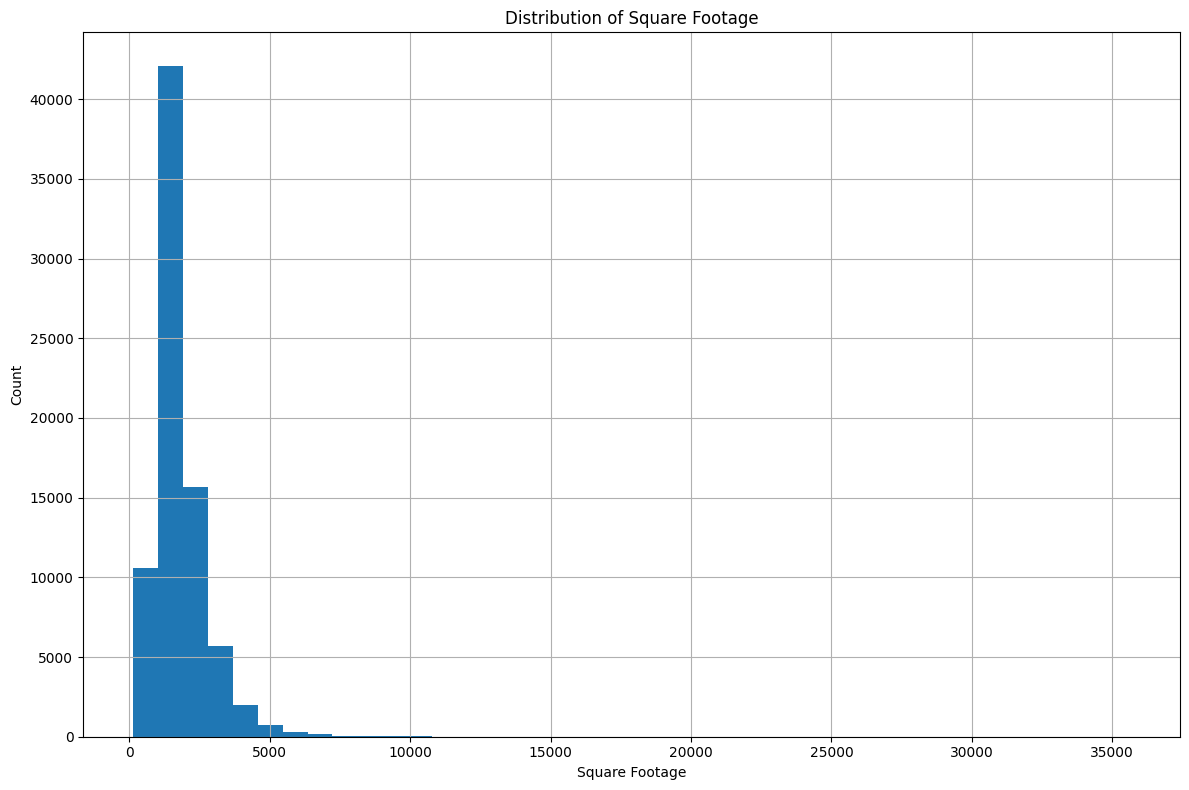

In [44]:
##Creating a histogram of the calculated square footage

plt.figure(figsize=(12, 8))
df['calculatedfinishedsquarefeet'].hist(bins=40)
plt.title('Distribution of Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Count')
# plt.xticks(year_ticks, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

/root/venv/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


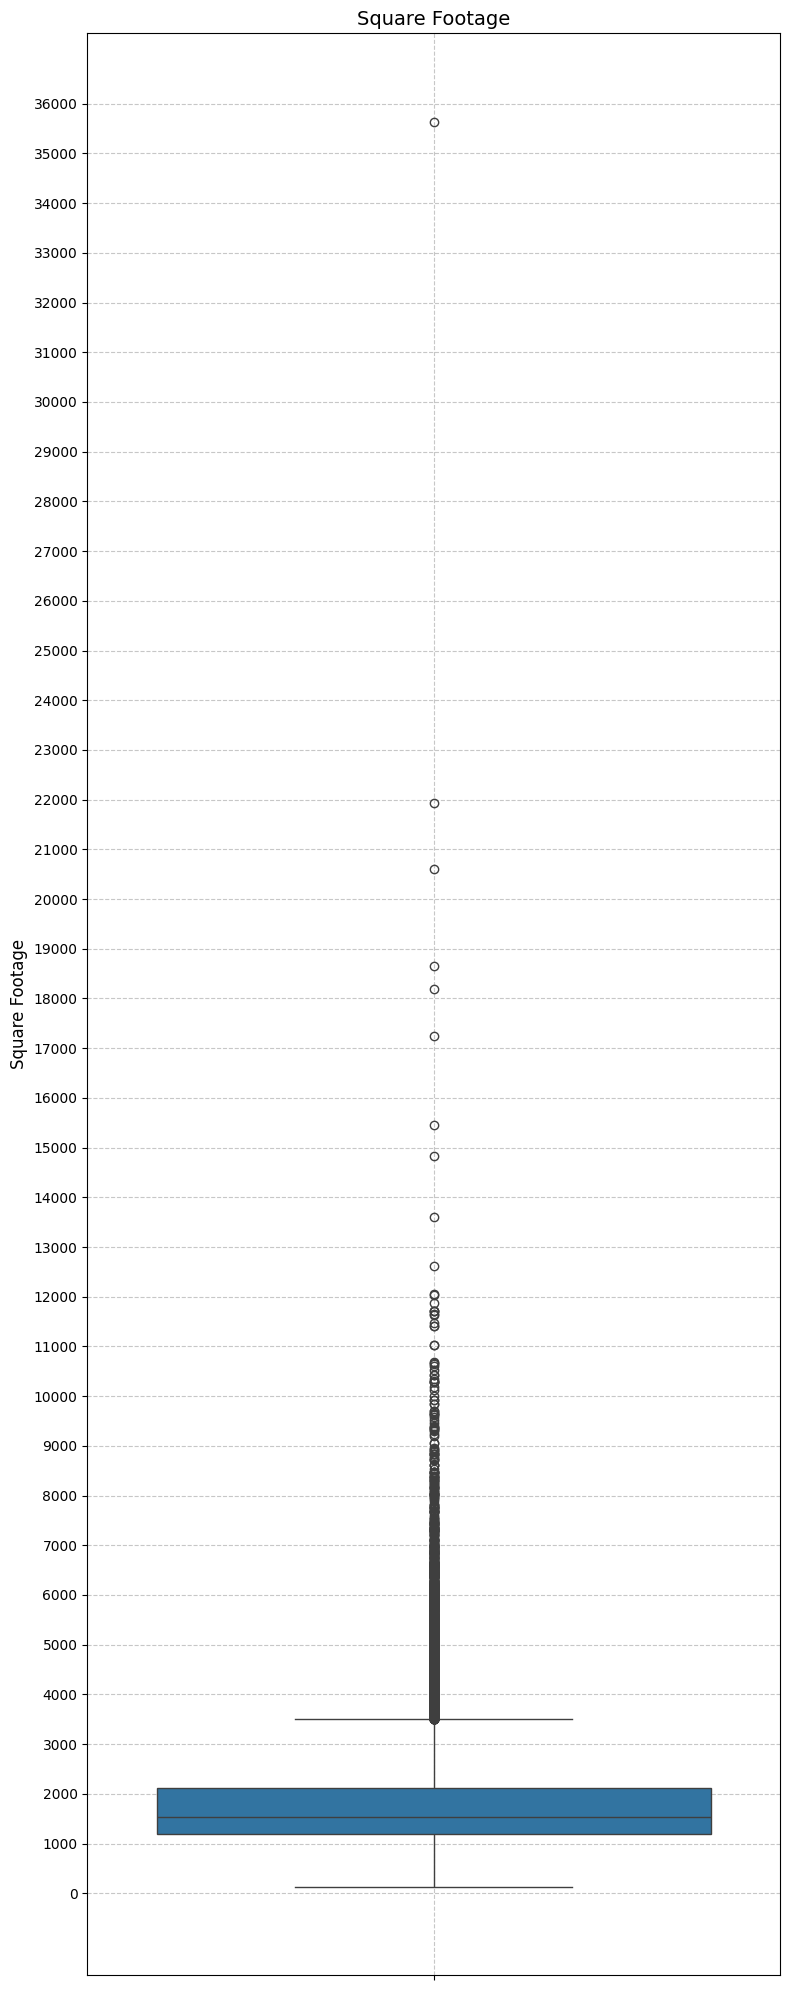

In [45]:
#Scatterplot of Square Footage
min_area = int(df['calculatedfinishedsquarefeet'].min() )
max_area = int(df['calculatedfinishedsquarefeet'].max())
area_ticks = np.arange(0, 37000, 1000)
fig, ax = plt.subplots(figsize=(8, 20))
sns.boxplot(y=df['calculatedfinishedsquarefeet'], ax=ax)
ax.set_title('Square Footage', fontsize=14)
ax.set_ylabel('Square Footage', fontsize=12)
ax.set_yticks(area_ticks)
ax.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [46]:
df.describe()

parcelid  airconditioningtypeid  architecturalstyletypeid  \
count  7.761300e+04           25007.000000                207.000000   
mean   1.300781e+07               1.812013                  7.386473   
std    3.518717e+06               2.965768                  2.728030   
min    1.071186e+07               1.000000                  2.000000   
25%    1.153821e+07               1.000000                  7.000000   
50%    1.253004e+07               1.000000                  7.000000   
75%    1.421101e+07               1.000000                  7.000000   
max    1.676893e+08              13.000000                 21.000000   

       basementsqft   bathroomcnt    bedroomcnt  buildingclasstypeid  \
count     50.000000  77579.000000  77579.000000            15.000000   
mean     679.720000      2.298496      3.053223             3.933333   
std      689.703546      0.996732      1.140480             0.258199   
min       38.000000      0.000000      0.000000             3.000000   
25%      273.000000      2.000000      2.000000             4.000000   
50%      515.000000      2.000000      3.000000             4.000000   
75%      796.500000      3.000000      4.000000             4.000000   
max     3560.000000     18.000000     16.000000             4.000000   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
count           49809.000000       76963.000000       614.0  ...   
mean                6.533779           2.316392        66.0  ...   
std                 1.722062           0.979689         0.0  ...   
min                 1.000000           1.000000        66.0  ...   
25%                 6.000000           2.000000        66.0  ...   
50%                 6.000000           2.000000        66.0  ...   
75%                 8.000000           3.000000        66.0  ...   
max                12.000000          18.000000        66.0  ...   

       typeconstructiontypeid       unitcnt  yardbuildingsqft17  \
count              223.000000  50703.000000         2393.000000   
mean                 6.040359      1.110309          305.460928   
std                  0.556035      1.169967          238.735241   
min                  4.000000      1.000000           11.000000   
25%                  6.000000      1.000000          170.000000   
50%                  6.000000      1.000000          250.000000   
75%                  6.000000      1.000000          364.000000   
max                 13.000000    237.000000         3191.000000   

       yardbuildingsqft26     yearbuilt  numberofstories  assessmentyear  \
count           70.000000  77309.000000     17599.000000         77579.0   
mean           216.385714   1968.611507         1.434286          2016.0   
std            190.177514     23.793171         0.544515             0.0   
min             12.000000   1824.000000         1.000000          2016.0   
25%             61.500000   1953.000000         1.000000          2016.0   
50%            164.500000   1970.000000         1.000000          2016.0   
75%            310.500000   1987.000000         2.000000          2016.0   
max            868.000000   2016.000000         6.000000          2016.0   

       taxdelinquencyyear  censustractandblock  taxvaluedollarcnt  
count         2900.000000         7.733200e+04       7.757800e+04  
mean            14.088276         6.049667e+13       4.901506e+05  
std              2.181281         1.533339e+12       6.537979e+05  
min              3.000000         6.037101e+13       1.000000e+03  
25%             14.000000         6.037311e+13       2.068985e+05  
50%             15.000000         6.037603e+13       3.588785e+05  
75%             15.000000         6.059042e+13       5.690000e+05  
max             99.000000         4.830301e+14       4.906124e+07  

[8 rows x 50 columns]

The total finished living area of the properties in the dataset also are skewed right. Most properties have under 3,500 square feet of living area. Any property above that is considered an outlier.

4. Calculated Bathnbr

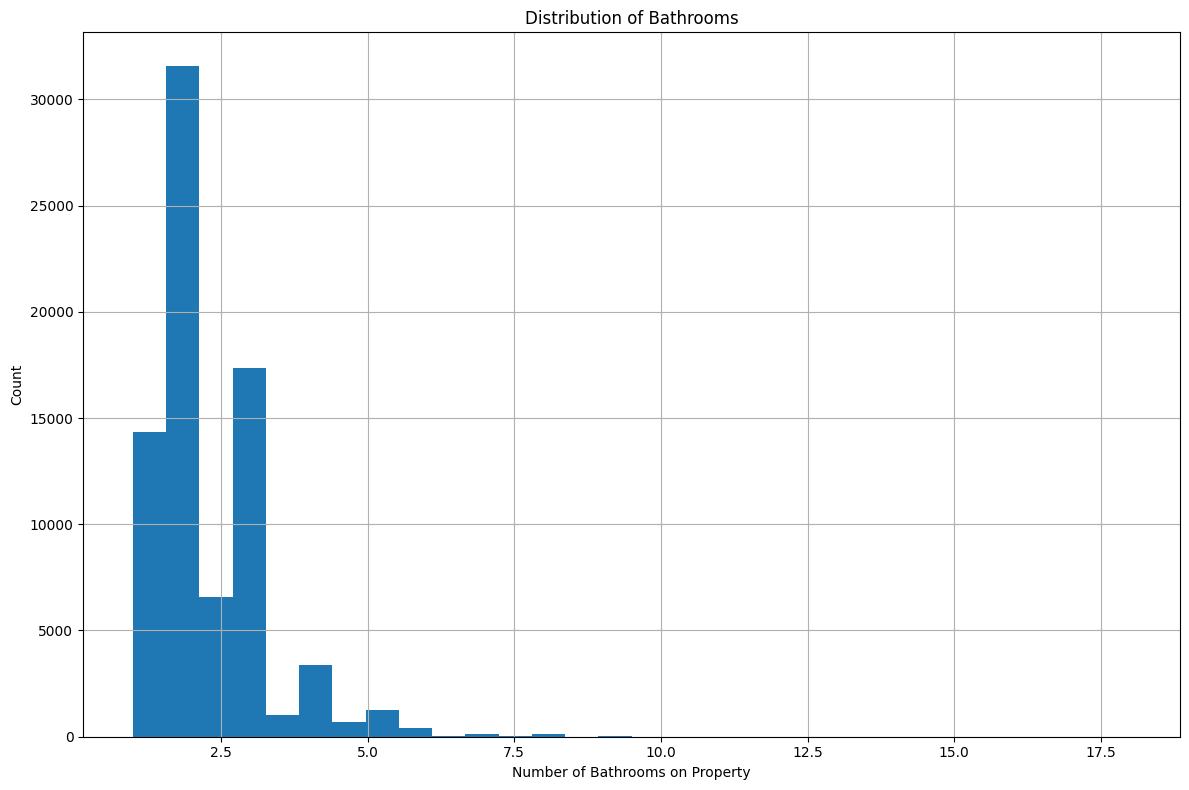

In [47]:
##Creating a histogram of the calculated whole bathrooms and half baths

plt.figure(figsize=(12, 8))
df['calculatedbathnbr'].hist(bins=30)
plt.title('Distribution of Bathrooms')
plt.xlabel('Number of Bathrooms on Property')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

/root/venv/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


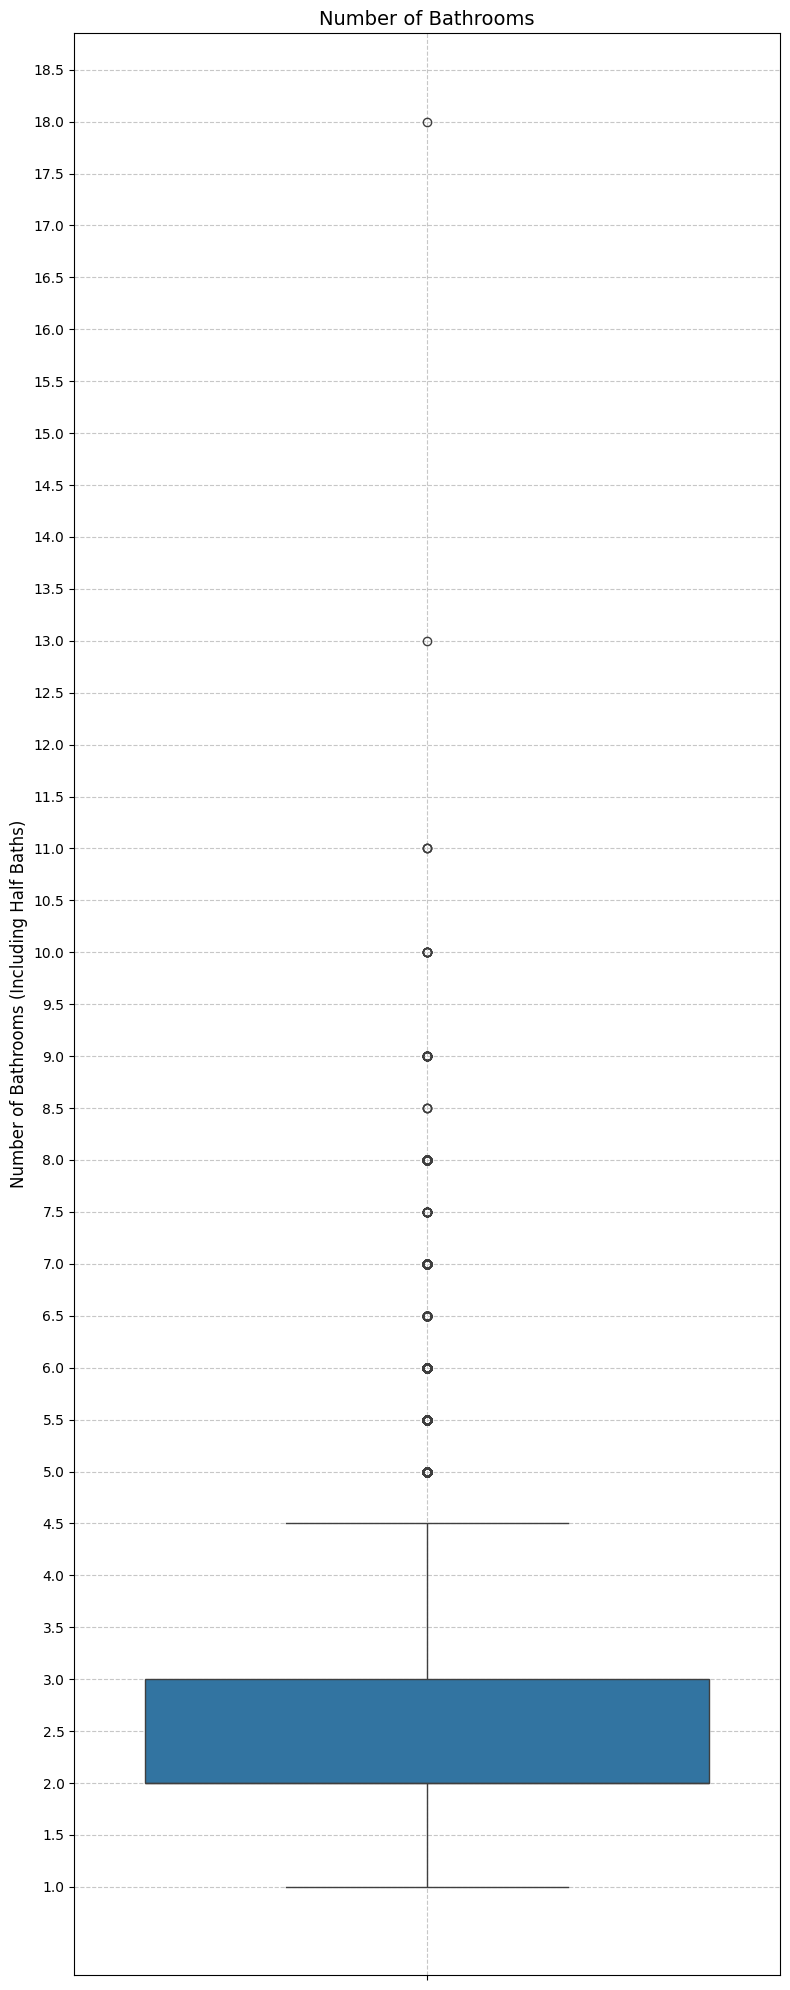

In [48]:
#Scatterplot of number of baths
min_bath = int(df['calculatedbathnbr'].min() )
max_bath = int(df['calculatedbathnbr'].max())
bath_ticks = np.arange(min_bath, max_bath + 1, 0.5)
fig, ax = plt.subplots(figsize=(8, 20))
sns.boxplot(y=df['calculatedbathnbr'], ax=ax)
ax.set_title('Number of Bathrooms', fontsize=14)
ax.set_ylabel('Number of Bathrooms (Including Half Baths)', fontsize=12)
ax.set_yticks(bath_ticks)
ax.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



calculatedbathnbr also has a skewed distirbution like the other variables. Most properties have between 2 and 3 bathrooms in total. Any properties with 5 or more bathrooms are an outlier. 

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


The histogram of the target variable, taxvaluedollarcnt, was right skewed. The visible portions of the histogram were all under 1,000,000 dollars. Looking at a boxplot of the target variable, almost every property that was within the interquartile range were almost under 1,000,000 dollars. The outliers were mostly concentrated below 10,000,000 dollars, while some outlier properties were between 10,000,000 and 25,000,000 dollars and one property even being assessed at 49,000,000 dollars. Since the properties in the dataset are all located within Southern California, it is realistic that properties would be assessed at these prices.  

For the feature exploration, we chose yearbuilt, calculatedfinishedsquarefeet, and calculatedbathnbr. We chose these three features because these are all three features that buyers often look at when purchasing a house. Yearbuilt was mostly concentrated between the 1950s and 1980s, with peaks in the 1950s,1980s, and 2000s. This would make sense due to the Post War housing boom and the housing booms that California experienced in the 80s and 00s. Properties that were built before the 1900s were outliers. Calculatedfinishedsquarefeet was skewed heavily right. Most properties have around 1000 to 2000 square feet of total finished living area. This feature also had outliers: properties reached upwards of 20,000 square feet and one property even had 35,640 square feet of finished living area. Calculatedbathnbr was right skewed and also had outliers. The histogram was centered around 2 with another peak at 3. Looking at the boxplot, properties with 5 or more bathrooms were outliers, with the outliers reaching 18 bathrooms. Like calculatedfinishedsquarefeet, properties in Southern California with this many bathrooms is feasible. 



## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [49]:
df['propertycountylandusecode'].value_counts(dropna=False)

propertycountylandusecode
0100    26782
122     13067
010C     8838
0101     6413
34       4932
        ...  
0115        1
105         1
020G        1
020M        1
020E        1
Name: count, Length: 76, dtype: int64

In [50]:
df['propertylandusetypeid'].value_counts(dropna=False)

propertylandusetypeid
261.0    52441
266.0    19342
246.0     2021
269.0     1947
248.0      729
247.0      539
265.0      335
263.0       74
275.0       59
260.0       42
NaN         34
267.0       29
31.0        15
264.0        6
Name: count, dtype: int64

In [51]:
df['propertyzoningdesc'].value_counts(dropna=False)

propertyzoningdesc
NaN          27137
LAR1          6766
LAR3          2450
LARS          1394
LBR1N         1225
             ...  
LCR112           1
PDM2*            1
RB4*             1
SMR2A-R2*        1
DUR18*           1
Name: count, Length: 1908, dtype: int64

In [52]:
df['censustractandblock'].value_counts(dropna=False)

censustractandblock
NaN             281
6.037137e+13     60
6.037277e+13     51
6.059032e+13     44
6.059063e+13     41
               ... 
6.037570e+13      1
6.037234e+13      1
6.037571e+13      1
6.037124e+13      1
6.037571e+13      1
Name: count, Length: 39007, dtype: int64

In [53]:
def drop_unsuitable_features(df, unsuitable_features):
    df_cleaned = df.copy()
    present_features = [col for col in unsuitable_features if col in df_cleaned.columns]    
    return df_cleaned.drop(columns=present_features)


unsuitable_features = [
    'parcelid', # Unique Identifier, not helpful for analysis
    'assessmentyear', # Only one unique value
    'fips', # Same value as regionidcounty
    'rawcensustractandblock', # Raw Version of CensustractandBlock
    'censustractandblock', # Too many unique values, already have lat/long and zip code
    'decktypeid', # Identifier with only 1 unique value
    'propertyzoningdesc', # Too many unique values, majority of values are null, uncertain if useful and what each code means
]

df_suitable_features = drop_unsuitable_features(df, unsuitable_features)


In [54]:
df_suitable_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25007 non-null  float64
 1   architecturalstyletypeid      207 non-null    float64
 2   basementsqft                  50 non-null     float64
 3   bathroomcnt                   77579 non-null  float64
 4   bedroomcnt                    77579 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   buildingqualitytypeid         49809 non-null  float64
 7   calculatedbathnbr             76963 non-null  float64
 8   finishedfloor1squarefeet      6037 non-null   float64
 9   calculatedfinishedsquarefeet  77378 non-null  float64
 10  finishedsquarefeet12          73923 non-null  float64
 11  finishedsquarefeet13          42 non-null     float64
 12  finishedsquarefeet15          3027 non-null   float64
 13  f

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


We dropped seven features from the dataset that were deemed unsuitable for a regression task. The parcelid column, a unique identifier for each property, provides no predictive value. assessmentyear was removed because all non null entries shared the same year, offering no variance. The fips column was redundant with regionidcounty, while rawcensustractandblock appeared to be a raw duplicate of censustractandblock. We also dropped censustractandblock itself, as we already have more informative location features like latitude, longitude, and ZIP code. Additionally, decktypeid was excluded due to having only a single unique value, and propertyzoningdesc was removed because it contained an overwhelming number of unique values, most of which were missing, and it was unclear whether those zoning codes would contribute meaningfully to the model.


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [55]:
show_null_counts_features(df)

The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
buildingclasstypeid 77598        99.98%   Numeric
finishedsquarefeet13 77571        99.95%   Numeric
basementsqft    77563        99.94%   Numeric
storytypeid     77563        99.94%   Numeric
yardbuildingsqft26 77543        99.91%   Numeric
fireplaceflag   77441        99.78%   Categorical
architecturalstyletypeid 77406        99.73%   Numeric
typeconstructiontypeid 77390        99.71%   Numeric
finishedsquarefeet6 77227        99.50%   Numeric
pooltypeid10    77148        99.40%   Numeric
decktypeid      76999        99.21%   Numeric
poolsizesum     76744        98.88%   Numeric
pooltypeid2     76539        98.62%   Numeric
hashottuborspa  76074        98.02%   Categorical
yardbuildingsqft17 75220        96.92%   Numeric
taxdelinquencyflag 74713        96.26%   Categorical
taxdelinquencyyear 74713        96.26%   Numeric
finishedsquarefeet15 74586        96.10%

In [56]:
def drop_too_many_null_features(df, threshold):
    df_cleaned = df.copy()
    missing_percentage = df_cleaned.isnull().mean()
    high_null_features = missing_percentage[missing_percentage > threshold].index
    print(f"Dropping features with more than {threshold*100}% missing values.")
    print("The following features will be dropped:")
    for i, col in enumerate(high_null_features, 1):
        print(f"{i}. {col}")
    return df_cleaned.drop(columns = high_null_features)

df_no_high_null = drop_too_many_null_features(df_suitable_features, 0.5)

Dropping features with more than 50.0% missing values.
The following features will be dropped:
1. airconditioningtypeid
2. architecturalstyletypeid
3. basementsqft
4. buildingclasstypeid
5. finishedfloor1squarefeet
6. finishedsquarefeet13
7. finishedsquarefeet15
8. finishedsquarefeet50
9. finishedsquarefeet6
10. fireplacecnt
11. garagecarcnt
12. garagetotalsqft
13. hashottuborspa
14. poolcnt
15. poolsizesum
16. pooltypeid10
17. pooltypeid2
18. pooltypeid7
19. regionidneighborhood
20. storytypeid
21. threequarterbathnbr
22. typeconstructiontypeid
23. yardbuildingsqft17
24. yardbuildingsqft26
25. numberofstories
26. fireplaceflag
27. taxdelinquencyflag
28. taxdelinquencyyear


In [57]:
df_no_high_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   77579 non-null  float64
 1   bedroomcnt                    77579 non-null  float64
 2   buildingqualitytypeid         49809 non-null  float64
 3   calculatedbathnbr             76963 non-null  float64
 4   calculatedfinishedsquarefeet  77378 non-null  float64
 5   finishedsquarefeet12          73923 non-null  float64
 6   fullbathcnt                   76963 non-null  float64
 7   heatingorsystemtypeid         49571 non-null  float64
 8   latitude                      77579 non-null  float64
 9   longitude                     77579 non-null  float64
 10  lotsizesquarefeet             69321 non-null  float64
 11  propertycountylandusecode     77579 non-null  object 
 12  propertylandusetypeid         77579 non-null  float64
 13  r

In [58]:
show_null_counts_features(df_no_high_null)

The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
heatingorsystemtypeid 28042        36.13%   Numeric
buildingqualitytypeid 27804        35.82%   Numeric
unitcnt         26910        34.67%   Numeric
lotsizesquarefeet 8292         10.68%   Numeric
finishedsquarefeet12 3690         4.75%   Numeric
regionidcity    1506         1.94%   Numeric
calculatedbathnbr 650          0.84%   Numeric
fullbathcnt     650          0.84%   Numeric
yearbuilt       304          0.39%   Numeric
calculatedfinishedsquarefeet 235          0.30%   Numeric
regionidzip     84           0.11%   Numeric
taxvaluedollarcnt 35           0.05%   Numeric
bathroomcnt     34           0.04%   Numeric
bedroomcnt      34           0.04%   Numeric
latitude        34           0.04%   Numeric
longitude       34           0.04%   Numeric
propertycountylandusecode 34           0.04%   Categorical
propertylandusetypeid 34           0.04%   Numeric
regio

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



In Part 3.B, we dropped 28 features from the dataset due to excessive missing values, defined as having more than 50% null entries. This threshold was chosen based on the rationale that when over half of the values in a column are missing, imputing or interpreting the feature becomes increasingly unreliable and may introduce more noise than value into the model. Among the features removed were those related to specific property amenities such as airconditioningtypeid, fireplacecnt, garagecarcnt, and several pool-related features (poolcnt, poolsizesum, pooltypeid10, etc.), which all had null rates exceeding 60%, with many above 90%. These features, while potentially useful in theory, were not well-represented across the dataset and therefore posed a risk of skewing results or requiring imputation assumptions that could not be justified. Additionally, features like regionidneighborhood and numberofstories were removed for the same reason. 

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [59]:
missing_counts = df_no_high_null.isnull().sum(axis=1).value_counts().sort_index()
print(missing_counts)

0     44120
1      4010
2      2701
3     19909
4      6267
5       317
6        62
7        13
8        93
9        79
10        4
11        4
20       34
Name: count, dtype: int64


In [60]:
def drop_problematic_samples(df, threshold):
    #Three Functions that clean the problematic samples


    def removed_null_target_samples(df):
        #Removes samples with null values in the target
        before = len(df)
        df_cleaned = df.dropna(subset=['taxvaluedollarcnt'])
        after = len(df_cleaned)
        print(f"Removed {before - after} rows with null target values.")
        return df_cleaned
    
    def too_many_null_values(df, threshold):
        # Removes samples with more than threshold % missing values
        before = len(df)
        under_threshold = df.isnull().mean(axis=1) < threshold
        df_cleaned = df[under_threshold]
        after = len(df_cleaned)
        print(f"Removed {before - after} rows with more than {threshold*100}% missing values.")
        return df_cleaned
    
    def drop_outliers(df):
        # Uses IQR to identify and remove outliers
        before = len(df)
        Q1 = df['taxvaluedollarcnt'].quantile(0.25)
        Q3 = df['taxvaluedollarcnt'].quantile(0.75)
        IQR = Q3 - Q1
        df_cleaned = df[(df['taxvaluedollarcnt'] >= Q1 - 1.5 * IQR) & (df['taxvaluedollarcnt'] <= Q3 + 1.5 * IQR)]
        after = len(df_cleaned)
        print(f"Removed {before - after} outliers within target variable.")
        return df_cleaned

    df_cleaned = df.copy()
    df_cleaned = removed_null_target_samples(df_cleaned)
    df_cleaned = too_many_null_values(df_cleaned, threshold)
    df_cleaned = drop_outliers(df_cleaned)
    return df_cleaned

In [61]:
df_no_problematic = drop_problematic_samples(df_no_high_null, 0.5)

Removed 35 rows with null target values.
Removed 8 rows with more than 50.0% missing values.
Removed 5184 outliers within target variable.


In [62]:
df_no_problematic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72386 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   72386 non-null  float64
 1   bedroomcnt                    72386 non-null  float64
 2   buildingqualitytypeid         46638 non-null  float64
 3   calculatedbathnbr             71869 non-null  float64
 4   calculatedfinishedsquarefeet  72246 non-null  float64
 5   finishedsquarefeet12          69014 non-null  float64
 6   fullbathcnt                   71869 non-null  float64
 7   heatingorsystemtypeid         46349 non-null  float64
 8   latitude                      72386 non-null  float64
 9   longitude                     72386 non-null  float64
 10  lotsizesquarefeet             64370 non-null  float64
 11  propertycountylandusecode     72386 non-null  object 
 12  propertylandusetypeid         72386 non-null  float64
 13  region

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


We created a nested function that removed three different types of problematic samples. The first function removed any rows that had a null value in the target feature. Any sample that had a null value was not helpful for analysis. The second function removed any rows that had more than 50% missing values. This was done as these samples might be difficult to impute and could introduce noise into the model. The third row removed any rows that were an outlier in the target feature, We used 1.5 x the IQR to identify and remove outliers. This was done to ensure that the outliers were not skewing the results.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [63]:
show_null_counts_features(df_no_problematic)

The dataset contains 72386 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
heatingorsystemtypeid 26037        35.97%   Numeric
buildingqualitytypeid 25748        35.57%   Numeric
unitcnt         25032        34.58%   Numeric
lotsizesquarefeet 8016         11.07%   Numeric
finishedsquarefeet12 3372         4.66%   Numeric
regionidcity    1371         1.89%   Numeric
calculatedbathnbr 517          0.71%   Numeric
fullbathcnt     517          0.71%   Numeric
yearbuilt       207          0.29%   Numeric
calculatedfinishedsquarefeet 140          0.19%   Numeric
regionidzip     34           0.05%   Numeric


In [64]:
missing_values = df_no_problematic.isnull().sum() / len(df_no_problematic) * 100
print(missing_values)

bathroomcnt                      0.000000
bedroomcnt                       0.000000
buildingqualitytypeid           35.570414
calculatedbathnbr                0.714227
calculatedfinishedsquarefeet     0.193408
finishedsquarefeet12             4.658359
fullbathcnt                      0.714227
heatingorsystemtypeid           35.969663
latitude                         0.000000
longitude                        0.000000
lotsizesquarefeet               11.073965
propertycountylandusecode        0.000000
propertylandusetypeid            0.000000
regionidcity                     1.894013
regionidcounty                   0.000000
regionidzip                      0.046970
roomcnt                          0.000000
unitcnt                         34.581273
yearbuilt                        0.285967
taxvaluedollarcnt                0.000000
dtype: float64


In [65]:
def impute_missing_values(df):
    def impute_numeric(df):
        #Using Median 
        df_cleaned = df.copy()
        numerical_features = df_cleaned.select_dtypes(include=['number']).columns.tolist()
        imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
        df_cleaned[numerical_features] = imp_median.fit_transform(df_cleaned[numerical_features])
        return df_cleaned
   
    def impute_categorical(df):
        #Using most_frequent 
        df_cleaned = df.copy()
        categorical_features = df_cleaned.select_dtypes(exclude=['number']).columns.tolist()
        imp_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        df_cleaned[categorical_features] = imp_frequent.fit_transform(df_cleaned[categorical_features])
        return df_cleaned

    df_cleaned = df.copy()
    df_cleaned = impute_numeric(df_cleaned)
    df_cleaned = impute_categorical(df_cleaned)
    print("Missing values after imputation:")
    print(df_cleaned.isnull().sum())
    return df_cleaned



In [66]:
df_imputed = impute_missing_values(df_no_problematic)


Missing values after imputation:
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fullbathcnt                     0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
taxvaluedollarcnt               0
dtype: int64


In [67]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72386 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   72386 non-null  float64
 1   bedroomcnt                    72386 non-null  float64
 2   buildingqualitytypeid         72386 non-null  float64
 3   calculatedbathnbr             72386 non-null  float64
 4   calculatedfinishedsquarefeet  72386 non-null  float64
 5   finishedsquarefeet12          72386 non-null  float64
 6   fullbathcnt                   72386 non-null  float64
 7   heatingorsystemtypeid         72386 non-null  float64
 8   latitude                      72386 non-null  float64
 9   longitude                     72386 non-null  float64
 10  lotsizesquarefeet             72386 non-null  float64
 11  propertycountylandusecode     72386 non-null  object 
 12  propertylandusetypeid         72386 non-null  float64
 13  region

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


In addressing the missing values in our dataset, we used two primary imputation strategies tailored to the nature of the features. For numerical features, we chose median imputation, which is robust against outliers and provides a central tendency estimate even when data is skewed. This method was especially appropriate for variables like lotsizesquarefeet, unitcnt, and buildingqualitytypeid, which had substantial proportions of missing data. Using the median instead of the mean prevents extreme values from distorting the imputed results. For categorical features, we applied most frequent (mode) imputation, which fills in missing values with the most commonly occurring category. This technique is suitable when categorical values do not follow a strict ordering and can help preserve the original distribution of the data. Features like propertycountylandusecode, which are string-based identifiers, benefited from this approach. Together, these imputation strategies ensured that all missing values were addressed while maintaining the integrity and structure of the dataset, enabling us to proceed with further analysis without introducing significant bias or data distortion.


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [68]:
# df['propertycountylandusecode'].value_counts()
# df['propertyzoningdesc'].value_counts()
# df['heatingorsystemtypeid'].value_counts()

In [69]:
categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['propertycountylandusecode'], dtype='object')


In [70]:
df_imputed['propertycountylandusecode'].value_counts()

propertycountylandusecode
0100    25395
122     11995
010C     8605
0101     5210
34       4896
        ...  
040G        1
105         1
020G        1
020M        1
020E        1
Name: count, Length: 68, dtype: int64

In [71]:
def encode_features(df, column_name):
    df_encoded = df.copy()
    frequencies = df_encoded[column_name].value_counts(normalize=True)
    df_encoded[column_name] = df_encoded[column_name].map(frequencies)
    return df_encoded


In [72]:
df_encoded = encode_features(df_imputed, 'propertycountylandusecode')

In [73]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72386 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   72386 non-null  float64
 1   bedroomcnt                    72386 non-null  float64
 2   buildingqualitytypeid         72386 non-null  float64
 3   calculatedbathnbr             72386 non-null  float64
 4   calculatedfinishedsquarefeet  72386 non-null  float64
 5   finishedsquarefeet12          72386 non-null  float64
 6   fullbathcnt                   72386 non-null  float64
 7   heatingorsystemtypeid         72386 non-null  float64
 8   latitude                      72386 non-null  float64
 9   longitude                     72386 non-null  float64
 10  lotsizesquarefeet             72386 non-null  float64
 11  propertycountylandusecode     72386 non-null  float64
 12  propertylandusetypeid         72386 non-null  float64
 13  region

In [79]:
df_cleaned = df_encoded.copy()

In [82]:
# df_cleaned.to_csv("zillow_cleaned.csv", index=False)

In [ ]:
# df = pd.read_csv("zillow_cleaned.csv")

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

1. Correlation Matrix

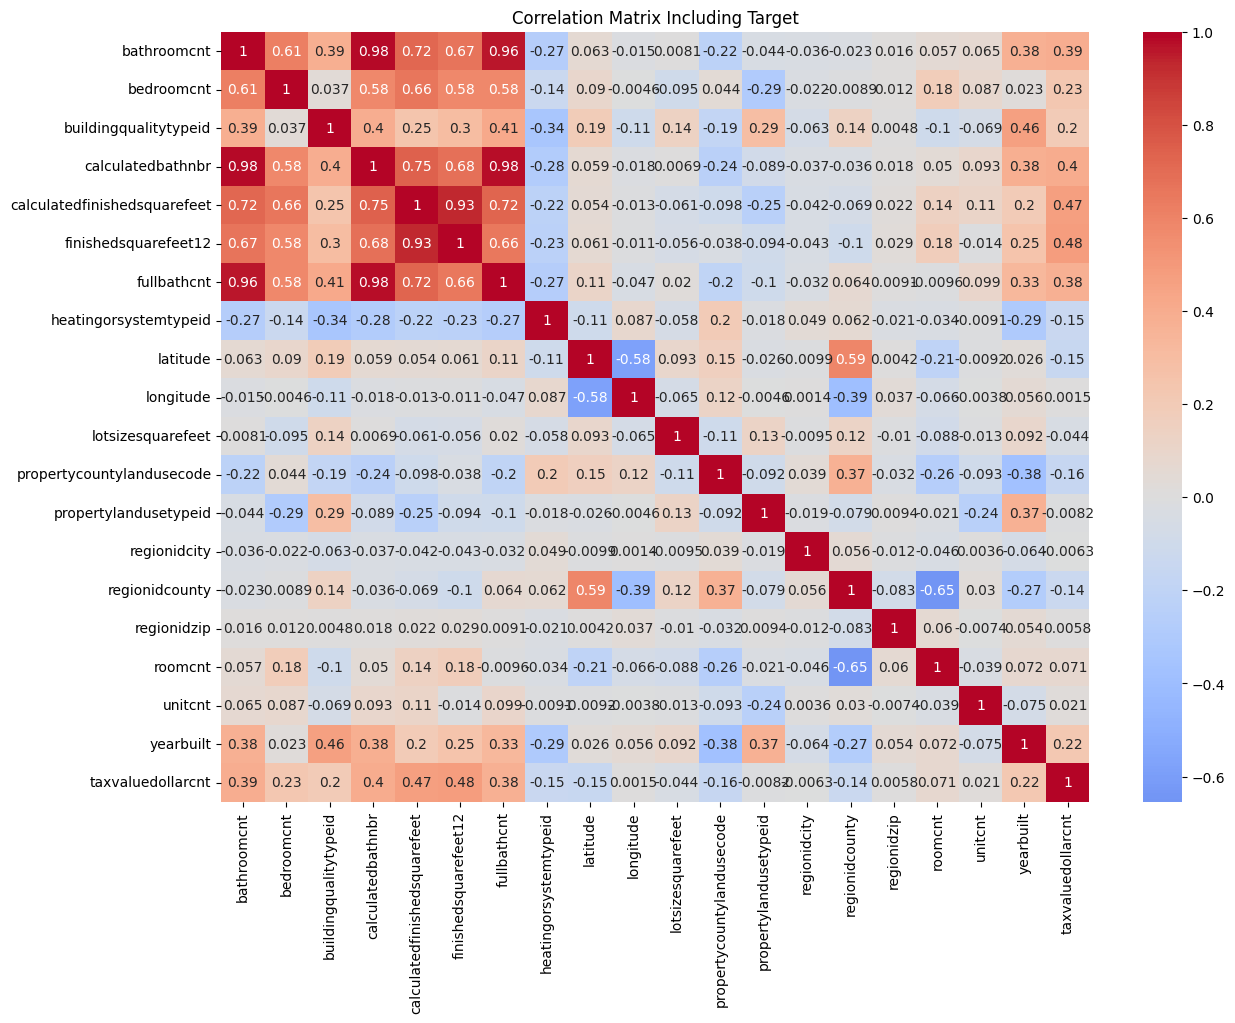

In [166]:
corr_matrix = df_cleaned.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Including Target")
plt.show()

2. F-Statistic

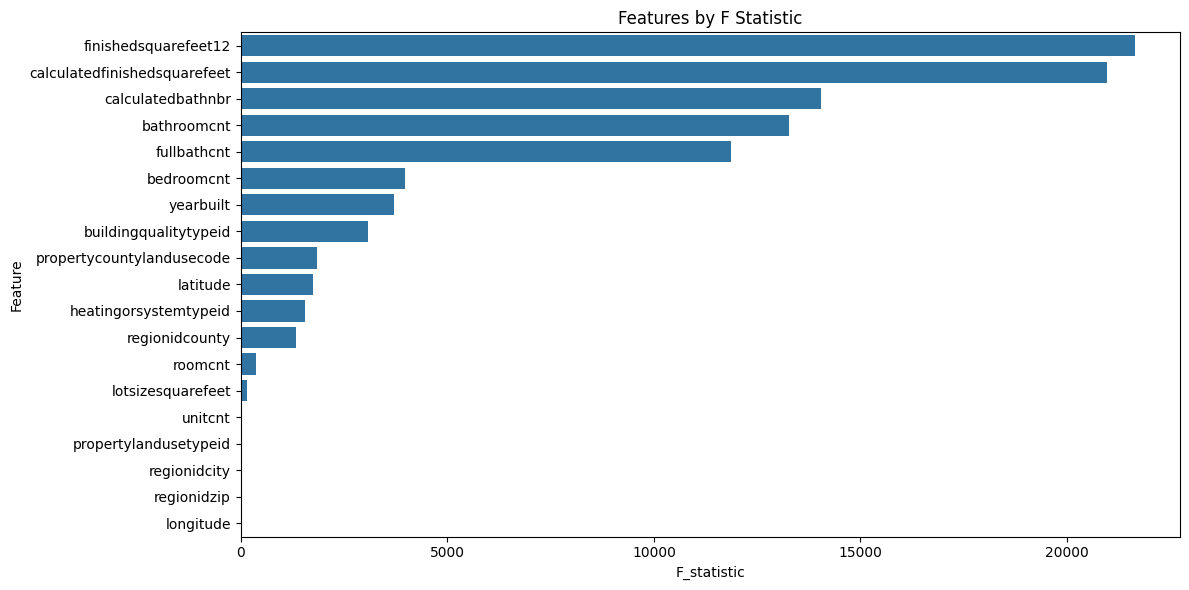

In [167]:
#Remove target variable
X = df_cleaned.drop(columns='taxvaluedollarcnt')
y = df_cleaned['taxvaluedollarcnt']

#  Calculate F statistic
f_values, p_values = f_regression(X, y)

# Store in DataFrame
stats_df = pd.DataFrame({
    'Feature': X.columns,
    'F_statistic': f_values,
    'p_value': p_values
})

#Sort Values by F Statistic
stats_df.sort_values(by='F_statistic', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=stats_df, x='F_statistic', y='Feature')
plt.title("Features by F Statistic")
plt.tight_layout()
plt.show()

3. Features with strong correlations

Features about the size of the property seem to be strongly correlated with one another. The three bathroom features all seem to have a high correlations with one another. Features such as finishedsquarefeet12 and calculatedfinishedsquarefeet are also correlated with one another. 

4. Feature Selection

In [179]:
# #Random Forest
# X = df_cleaned.drop(columns='taxvaluedollarcnt')
# y = df_cleaned['taxvaluedollarcnt']
# rf = RandomForestRegressor(random_state=42)

# # Forward selection
# forward_selector = SequentialFeatureSelector(rf, n_features_to_select=10, direction='forward', cv=2, n_jobs=-1)
# forward_selector.fit(X, y)
# forward_features = X.columns[forward_selector.get_support()]

# # Backward selection
# backward_selector = SequentialFeatureSelector(rf, n_features_to_select=10, direction='backward', cv=2, n_jobs=-1)
# backward_selector.fit(X, y)
# backward_features = X.columns[backward_selector.get_support()]

# print("Top 10 Forward-Selected Features:\n", forward_features.tolist())
# print("\nTop 10 Backward-Selected Features:\n", backward_features.tolist())


In [91]:
#Random Forest
X = df_cleaned.drop(columns='taxvaluedollarcnt')
y = df_cleaned['taxvaluedollarcnt']
rf = RandomForestRegressor(random_state=42)

# Forward selection
forward_selector = SequentialFeatureSelector(rf, n_features_to_select=10, direction='forward', cv=2, n_jobs=-1)
forward_selector.fit(X, y)
forward_features = X.columns[forward_selector.get_support()]
print("Top 10 Forward-Selected Features:\n", forward_features.tolist())

/Users/nicomcgreevey/Library/Python/3.12/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top 10 Forward-Selected Features:
 ['bathroomcnt', 'calculatedbathnbr', 'fullbathcnt', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt']


In [182]:
# # #Random Forest
# X = df_cleaned.drop(columns='taxvaluedollarcnt')
# y = df_cleaned['taxvaluedollarcnt']
# rf = RandomForestRegressor(random_state=42)

# # Backward selection
# backward_selector = SequentialFeatureSelector(rf, n_features_to_select=10, direction='backward', cv=2, n_jobs=-1)
# backward_selector.fit(X, y)
# backward_features = X.columns[backward_selector.get_support()]
# print("\nTop 10 Backward-Selected Features:\n", backward_features.tolist())


In [183]:
# #Bagging Regressor
# X = df_cleaned.drop(columns='taxvaluedollarcnt')
# y = df_cleaned['taxvaluedollarcnt']
# bag = BaggingRegressor(random_state=42)

# # Forward selection
# forward_selector_bag = SequentialFeatureSelector(bag, n_features_to_select=10, direction='forward', cv=2, n_jobs=-1)
# forward_selector_bag.fit(X, y)
# forward_features_bag = X.columns[forward_selector_bag.get_support()]

# # Backward selection
# backward_selector_bag = SequentialFeatureSelector(bag, n_features_to_select=10, direction='backward', cv=2, n_jobs=-1)
# backward_selector_bag.fit(X, y)
# backward_features_bag = X.columns[backward_selector_bag.get_support()]

# print("Top 10 Forward-Selected Features (Bagging):\n", forward_features_bag.tolist())
# print("\nTop 10 Backward-Selected Features (Bagging):\n", backward_features_bag.tolist())

In [184]:
# #GradientBoostingRegressor
# X = df_cleaned.drop(columns='taxvaluedollarcnt')
# y = df_cleaned['taxvaluedollarcnt']
# gbr = GradientBoostingRegressor(random_state=42)

# # Forward selection
# forward_selector_gbr = SequentialFeatureSelector(gbr, n_features_to_select=10, direction='forward', cv=2, n_jobs=-1)
# forward_selector_gbr.fit(X, y)
# forward_features_gbr = X.columns[forward_selector_gbr.get_support()]

# # Backward selection
# backward_selector_gbr = SequentialFeatureSelector(gbr, n_features_to_select=10, direction='backward', cv=2, n_jobs=-1)
# backward_selector_gbr.fit(X, y)
# backward_features_gbr = X.columns[backward_selector_gbr.get_support()]

# print("Top 10 Forward-Selected Features (Gradient Boosting):\n", forward_features_gbr.tolist())
# print("\nTop 10 Backward-Selected Features (Gradient Boosting):\n", backward_features_gbr.tolist())

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



Several features demonstrate strong positive correlations with one another, particularly those related to the physical size and attributes of a property. For instance, calculatedbathnbr, bathroomcnt, and fullbathcnt are nearly perfectly correlated with each other, suggesting they likely capture the same underlying information about the number of bathrooms in a property. Similarly, features like finishedsquarefeet12 and calculatedfinishedsquarefeet also show high correlation values (around 0.47–0.48) with the target variable, confirming that larger homes are generally assessed at higher tax values. The number of bedrooms (bedroomcnt) and total rooms (roomcnt) are also positively correlated with property value, as expected in real estate.

On the other hand, some features display little to no correlation with the target. Categorical or location-based identifiers such as regionidzip, regionidcounty, and regionidcity have very low correlations with taxvaluedollarcnt, indicating they may not provide strong predictive power in their raw form. Interestingly, the geographic coordinates latitude and longitude show a moderate negative correlation with each other (about -0.58), which reflects the spatial distribution of properties across the dataset's regional scope, though their individual relationships with the target are weak. Features like heatingorsystemtypeid and propertylandusetypeid also have weak or negative correlations with most variables including the target, potentially due to missing data or categorical variability not captured in a simple correlation.


### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

1. Patterns among Features and Target Value

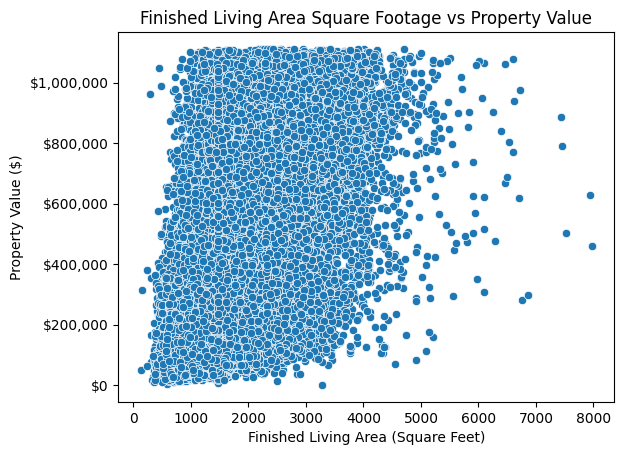

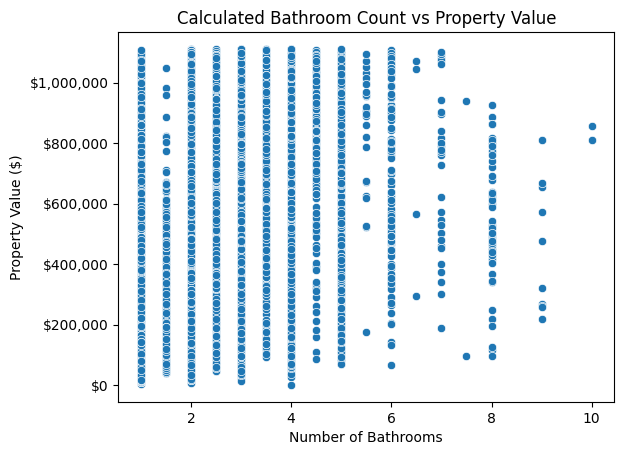

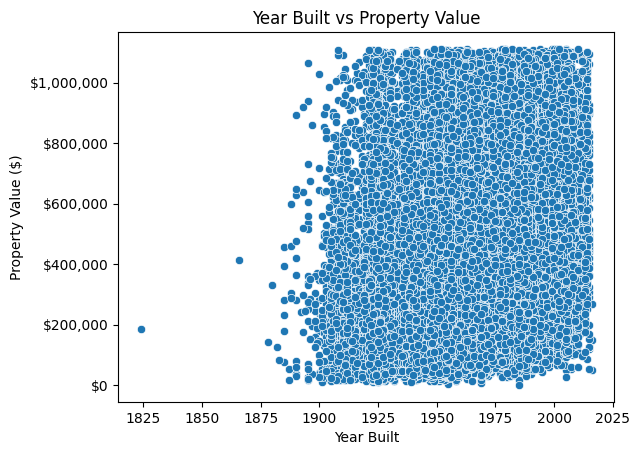

In [185]:
# Scatterplot 1: Finished Living Area Square Footage vs Property Value
ax = sns.scatterplot(data=df_cleaned, x='finishedsquarefeet12', y='taxvaluedollarcnt')
plt.title("Finished Living Area Square Footage vs Property Value")
plt.xlabel("Finished Living Area (Square Feet)")
plt.ylabel("Property Value ($)")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.show()

# Scatterplot 2: Calculated Bathroom Count vs Property Value
ax = sns.scatterplot(data=df_cleaned, x='calculatedbathnbr', y='taxvaluedollarcnt')
plt.title("Calculated Bathroom Count vs Property Value")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Property Value ($)")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.show()

# Scatterplot 3: Year Built vs Property Value
ax = sns.scatterplot(data=df_cleaned, x='yearbuilt', y='taxvaluedollarcnt')
plt.title("Year Built vs Property Value")
plt.xlabel("Year Built")
plt.ylabel("Property Value ($)")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.show()

2. Patterns among 2 Features

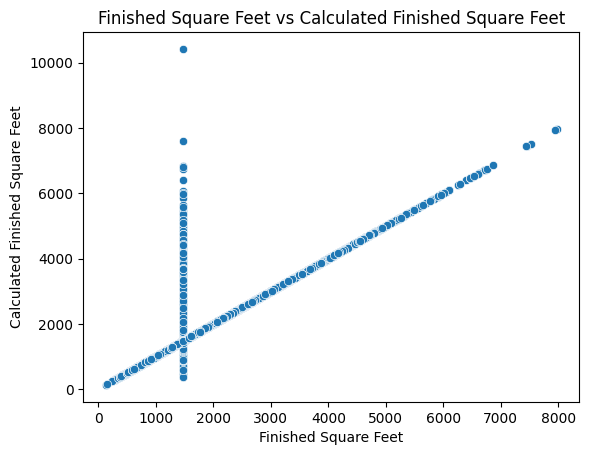

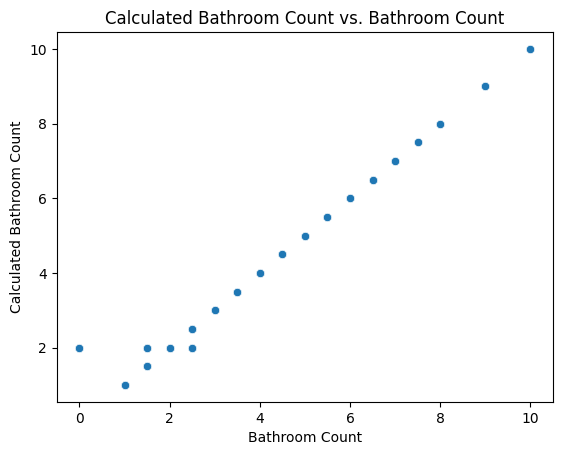

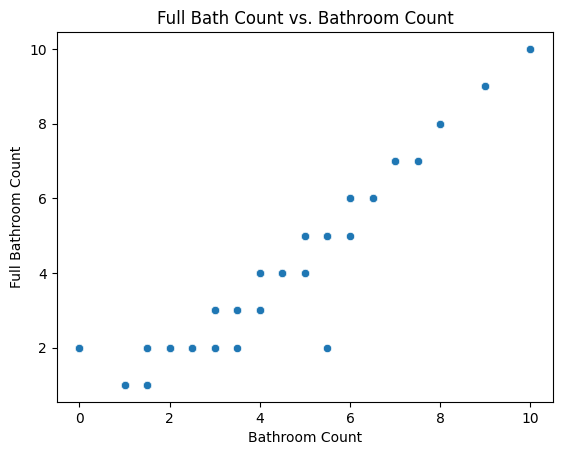

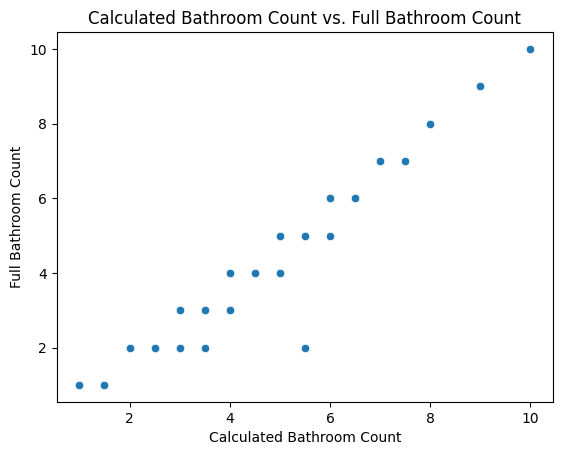

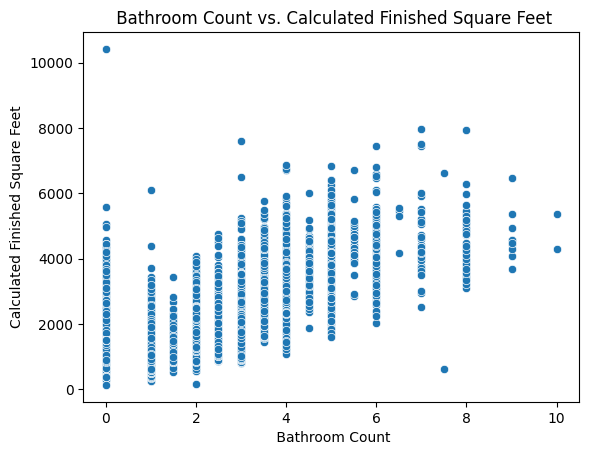

In [186]:
# Scatterplot 1: Finished Square Feet vs Calculated Finished Square Feet
ax = sns.scatterplot(data=df_cleaned, x='finishedsquarefeet12', y='calculatedfinishedsquarefeet')
plt.title("Finished Square Feet vs Calculated Finished Square Feet")
plt.xlabel("Finished Square Feet")
plt.ylabel("Calculated Finished Square Feet")
plt.show()

# Scatterplot 2A: Bathroom Count vs Calculated Bathroom Count
ax = sns.scatterplot(data=df_cleaned, x='bathroomcnt', y='calculatedbathnbr')
plt.title("Calculated Bathroom Count vs. Bathroom Count")
plt.xlabel("Bathroom Count")
plt.ylabel("Calculated Bathroom Count")
plt.show()

# Scatterplot 2B: Bathroom Count vs Full Bathroom Count
ax = sns.scatterplot(data=df_cleaned, x='bathroomcnt', y='fullbathcnt')
plt.title("Full Bath Count vs. Bathroom Count")
plt.xlabel("Bathroom Count")
plt.ylabel("Full Bathroom Count")
plt.show()

# Scatterplot 2C: Bathroom Count vs Full Bathroom Count
ax = sns.scatterplot(data=df_cleaned, x='calculatedbathnbr', y='fullbathcnt')
plt.title("Calculated Bathroom Count vs. Full Bathroom Count")
plt.xlabel("Calculated Bathroom Count")
plt.ylabel("Full Bathroom Count")
plt.show()

# Scatterplot 3: Bathroom Count vs Finished Square Feet
ax = sns.scatterplot(data=df_cleaned, x='bathroomcnt', y='calculatedfinishedsquarefeet')
plt.title(" Bathroom Count vs. Calculated Finished Square Feet")
plt.xlabel(" Bathroom Count")
plt.ylabel("Calculated Finished Square Feet")
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.





Comparing the features to the target variable:
1. Finished Living Area Square Footage vs. Property Value
The scatterplot shows a positive relationship between living area and property value, with a high concentration of properties between 1,000 and 3,500 square feet. However, the spread of values is wide across all size ranges, and some larger homes still have relatively low property values. This indicates that square footage alone does not fully explain property value.


2. Calculated Bathroom Count vs. Property Value
The scatterplot reveals substantial overlap in property values across different bathroom counts. For example, some homes with 3 bathrooms are valued higher than those with 6, suggesting that bathroom count is only one of many factors influencing property value and may interact with others like size or location.

3. Year Built vs. Property Value
There is no strong linear trend between year built and property value. Most properties built after the 1920s tend to fall within a similar value range. This suggests that the year a home was built contributes modestly to its value and must be considered alongside other features, as reflected in the relatively low correlation between year built and property value.


Comparing the non target features:

1. Finished Square Feet vs. Calculated Finished Square Feet 
The scatterplot has a clear diagonal line indicating that finished square footage and calculated finished square footage are closely aligned. However, there is a vertical cluster of points at around 1,500 finished square feet, which would be the samples that had missing Finished Square Feet that had been imputed by the median. 


2. Bathroom Count vs. Calculated Finished Square Feet
There is a loose positive trend between bathroom count and the calculated finished square footage. In general, properties with more bathrooms tend to be larger in size, though there is noticeable spread in the data. For example, properties with 4-6 bathrooms can have square footage ranging from around 1,000 to over 6,000 square feet. This suggests that while more bathrooms often accompany larger homes, there are exceptions and outliers that deviate from this trend. 

3. Bathroom Count, Full Bathroom Count, and Calculated Bathroom Count
The relationship among the three bathroom features are all highly linear and tightly clustered, as seen by the strong correlation values in the correlation matrix. The calculated and full bath counts track closely, likely because full baths are a core component of the calculated value. Also, total bathroom count strongly aligns with full bath count, with some deviations due to the presence of partial baths. These consistent overlaps across all three features suggest they are effectively capturing the same information and may be suitable for consolidation to simplify the model.



## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [187]:
def create_property_age(df):
    df_age = df.copy()
    df_age['property_age'] = 2025 - df_age['yearbuilt']
    return df_age

def create_ratio(df, column1, column2):
    df_ratio = df.copy()
    new_col_name = f'{column1}_to_{column2}_ratio'
    df_ratio[new_col_name] = df_ratio[column1] / df_ratio[column2]
    return df_ratio

def log_transform(df, columns):
    df_log = df.copy()
    for col in columns:
        new_col_name = f'log_{col}'
        df_log[new_col_name] = np.log1p(df_log[col])
    return df_log

def standardizer(df, columns):
    df_scaled = df.copy()
    scaler = StandardScaler()
    for col in columns:
        new_col_name = f'standardized_{col}'
        df_scaled[new_col_name] = scaler.fit_transform(df_scaled[[col]])
    return df_scaled

                   property_age  taxvaluedollarcnt
property_age            1.00000           -0.22083
taxvaluedollarcnt      -0.22083            1.00000


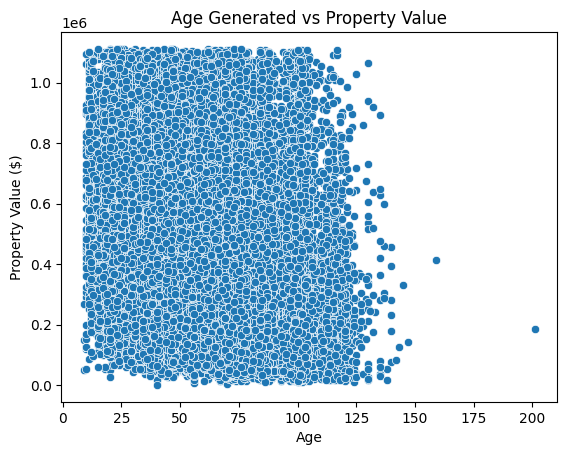

In [188]:
#House Age
df_engineering = df_cleaned.copy()
df_engineering = create_property_age(df_engineering)

age_corr = df_engineering[['property_age', 'taxvaluedollarcnt']].corr()
print(age_corr)

sns.scatterplot(data=df_engineering, x='property_age', y='taxvaluedollarcnt')
plt.title("Age Generated vs Property Value")
plt.xlabel("Age")
plt.ylabel("Property Value ($)")
plt.show()

                   property_age  taxvaluedollarcnt
property_age            1.00000           -0.22083
taxvaluedollarcnt      -0.22083            1.00000


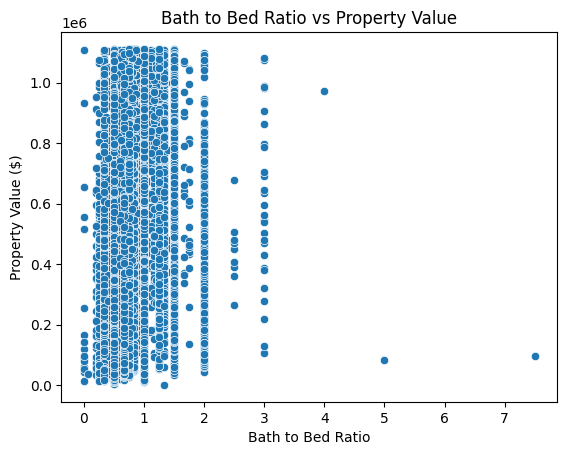

In [189]:
#Create Bedroom to Bathroom Ratio
df_engineering = create_ratio(df_engineering, 'bathroomcnt', 'bedroomcnt')

ratio_corr = df_engineering[['bathroomcnt_to_bedroomcnt_ratio', 'taxvaluedollarcnt']].corr()
print(age_corr)

sns.scatterplot(data=df_engineering, x='bathroomcnt_to_bedroomcnt_ratio', y='taxvaluedollarcnt')
plt.title("Bath to Bed Ratio vs Property Value")
plt.xlabel("Bath to Bed Ratio")
plt.ylabel("Property Value ($)")
plt.show()

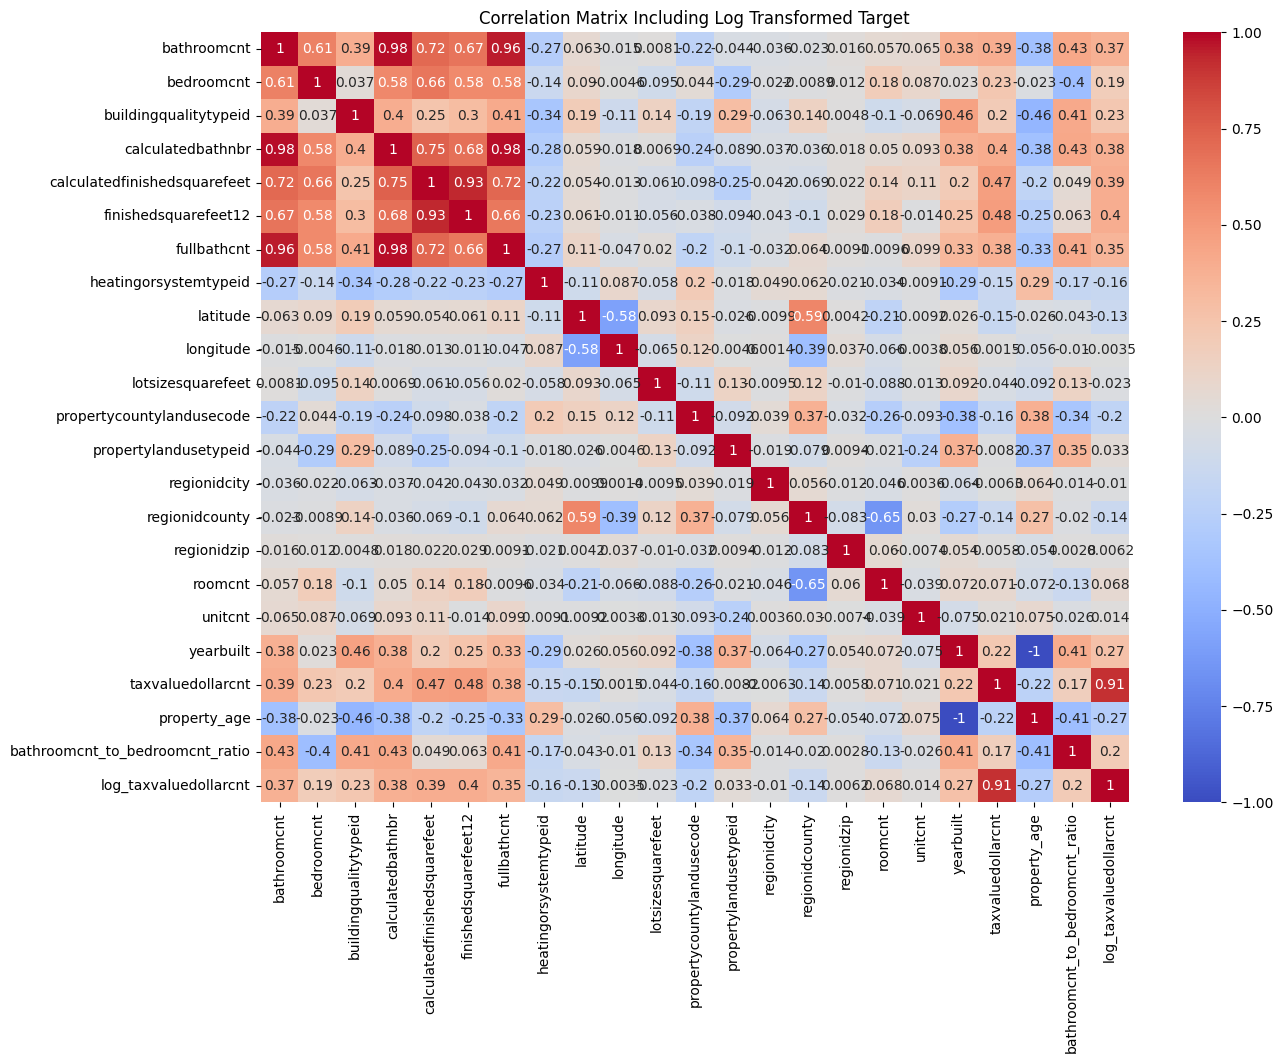

In [190]:
#Log Tax Value
# df_engineering_log = df_engineering.copy()
df_engineering = log_transform(df_engineering, ['taxvaluedollarcnt'])

log_target_corr = df_engineering.corr()
# print(log_target_corr)

plt.figure(figsize=(14, 10))
sns.heatmap(log_target_corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Including Log Transformed Target")
plt.show()

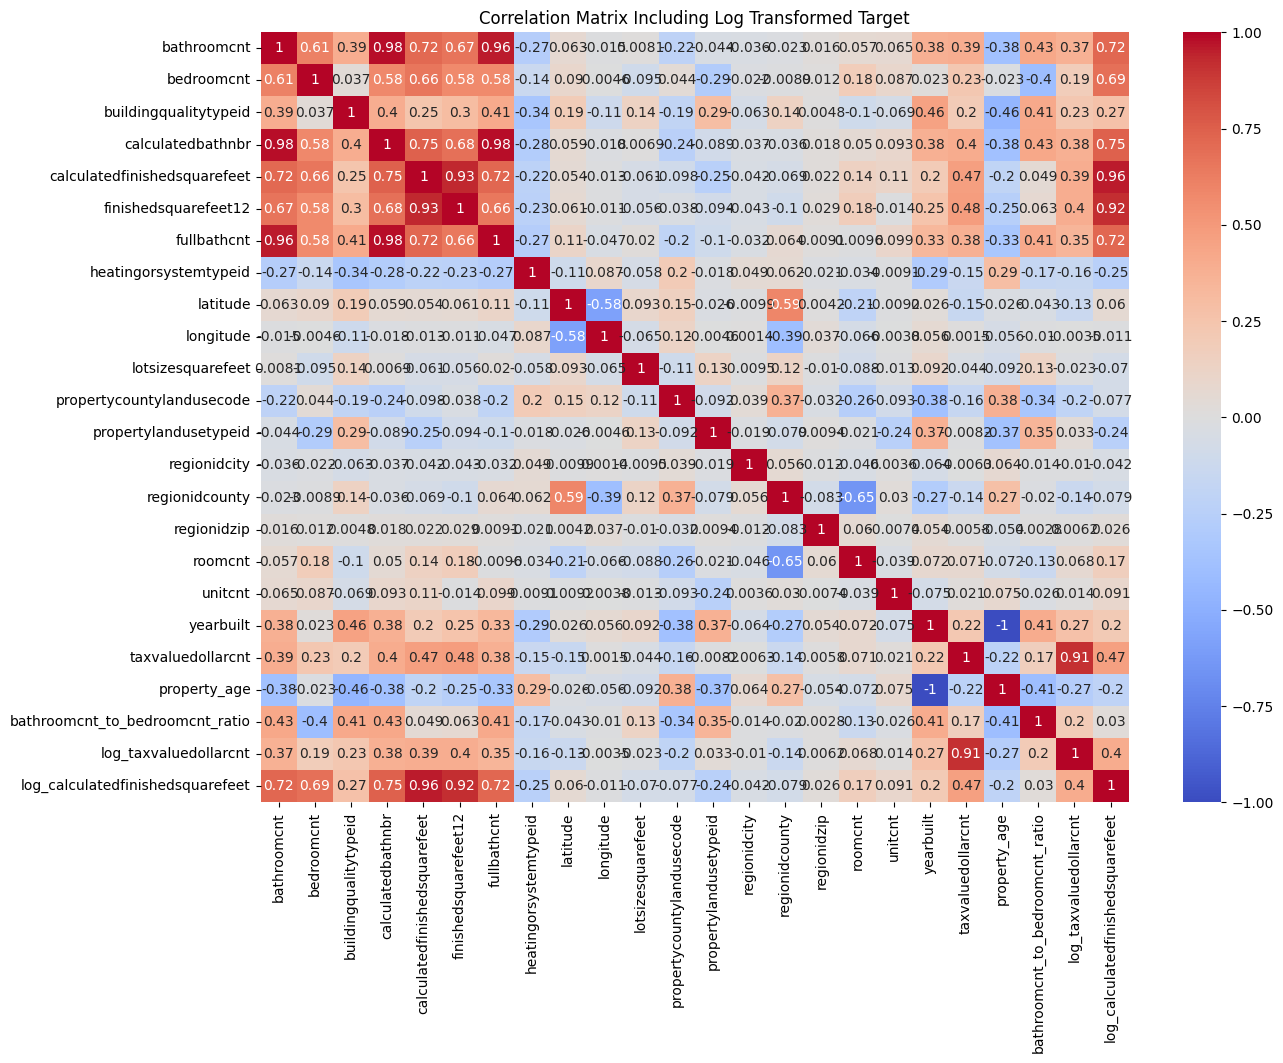

In [191]:
#Log Calculated Square Footage
# df_engineering_log = df_engineering.copy()
df_engineering = log_transform(df_engineering, ['calculatedfinishedsquarefeet'])

log_target_corr = df_engineering.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(log_target_corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Including Log Transformed Target")
plt.show()

                                   standardized_finishedsquarefeet12  \
standardized_finishedsquarefeet12                           1.000000   
taxvaluedollarcnt                                           0.479838   

                                   taxvaluedollarcnt  
standardized_finishedsquarefeet12           0.479838  
taxvaluedollarcnt                           1.000000  


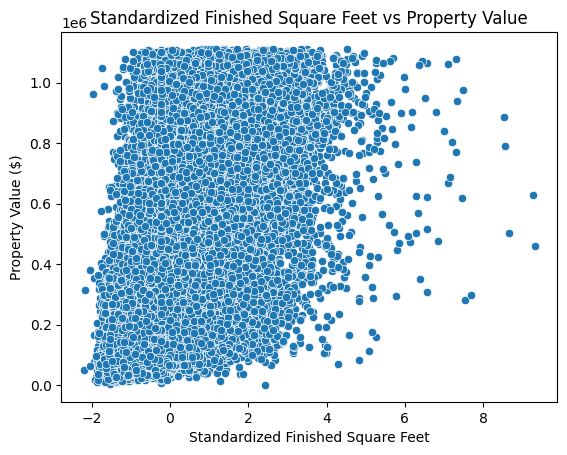

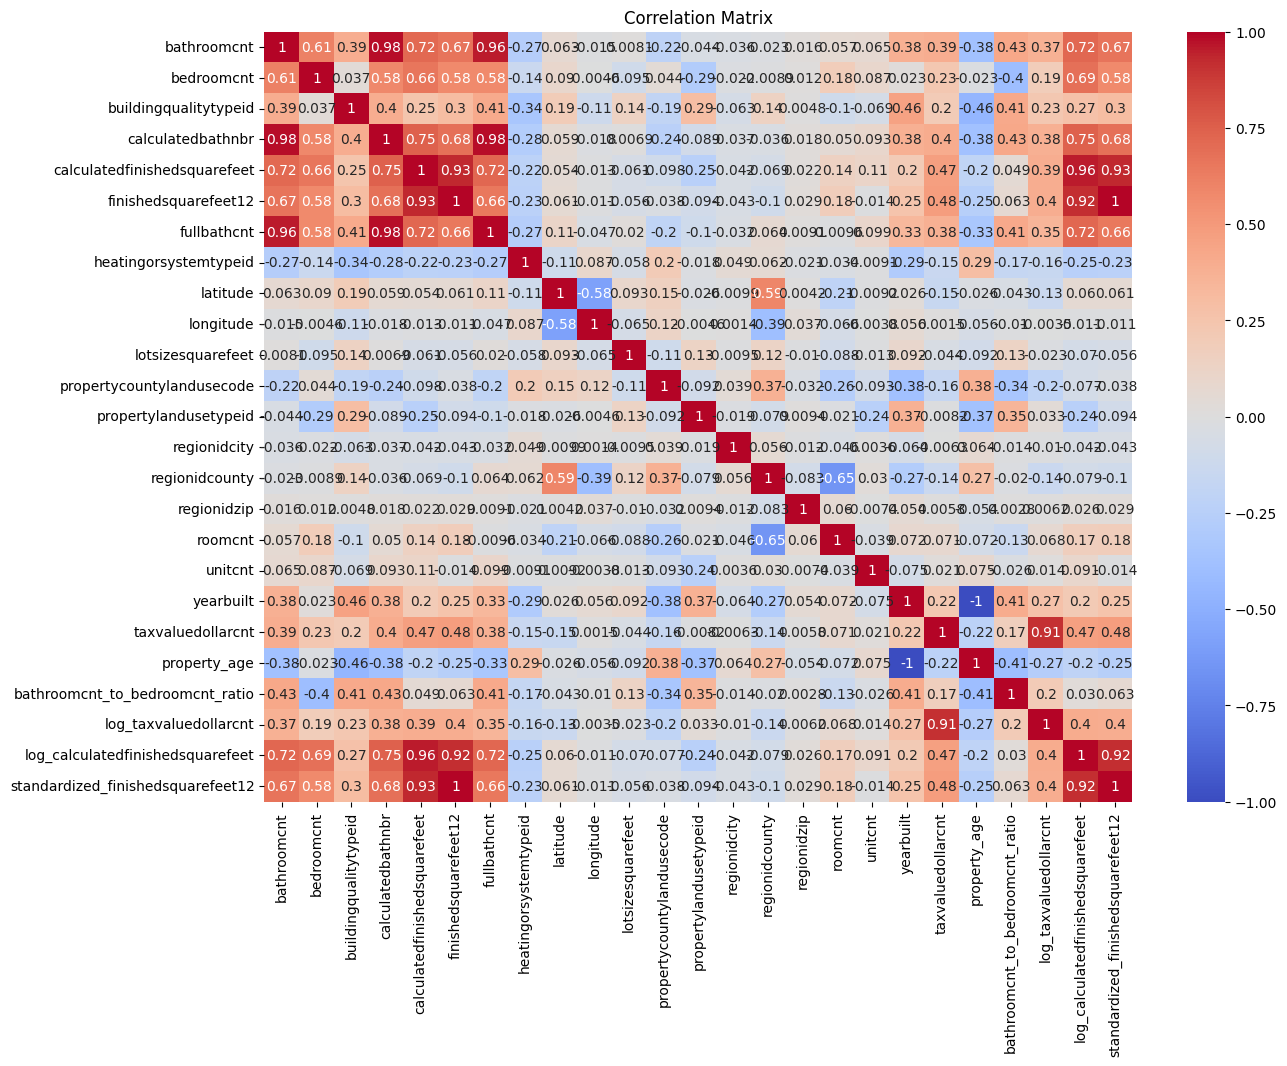

In [192]:
#Standardize CalculatedFinishedSquareFeet
df_engineering = standardizer(df_engineering, ['finishedsquarefeet12'])
stand_corr = df_engineering.corr()

ratio_corr = df_engineering[['standardized_finishedsquarefeet12', 'taxvaluedollarcnt']].corr()
print(ratio_corr)

sns.scatterplot(data=df_engineering, x='standardized_finishedsquarefeet12', y='taxvaluedollarcnt')
plt.title("Standardized Finished Square Feet vs Property Value")
plt.xlabel("Standardized Finished Square Feet")
plt.ylabel("Property Value ($)")
plt.show()

plt.figure(figsize=(14, 10))
sns.heatmap(stand_corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [193]:
df_engineering_2 = df_cleaned.copy()
df_engineering_2['property_age'] = 2025 - df_engineering_2['yearbuilt']
df_engineering_2['bath_to_bed_ratio'] = df_engineering_2['bathroomcnt'] / df_engineering_2['bedroomcnt'].replace(0, np.nan)
df_engineering_2['log_taxvalue'] = np.log1p(df_engineering_2['taxvaluedollarcnt'])
correlation_results_2 = df_engineering_2[['property_age', 'bath_to_bed_ratio', 'log_taxvalue', 'taxvaluedollarcnt']].corr()
print(correlation_results_2)

                   property_age  bath_to_bed_ratio  log_taxvalue  \
property_age           1.000000          -0.406037     -0.270554   
bath_to_bed_ratio     -0.406037           1.000000      0.198664   
log_taxvalue          -0.270554           0.198664      1.000000   
taxvaluedollarcnt     -0.220830           0.166690      0.912670   

                   taxvaluedollarcnt  
property_age                -0.22083  
bath_to_bed_ratio            0.16669  
log_taxvalue                 0.91267  
taxvaluedollarcnt            1.00000  


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


The three transformations used in part 5 were finding and reducing skewness and improving patterns. For the first transformation, yearbuilt would be changed to 'property_age'. We looked at yearbuilt in particular because the dataset had so many missing values, and based on the histogram in part 2, there was a large left skew with homes being built between 1950 and 1980. This range of home may not sit well with most buyers in today's age, so to account for the skewness, and many missing values, we decided to create a new feature which was property_age which was done by the current year we are in by yearbuilt to give us a better representation to how old the properties are with a value many will understand, and make the models produced easier to read. 

Next, we looked at the bathroom-to-bedroom ratio. This was done by dividing bathrooms by bedrooms. This was useful because it will help the buyer and agent to better address the property details. An example is someone may not want a 2-bed 4-bath home and may be suited better with a 2-bed and 2-bath home. Both may have the same perceived square footage, but different layouts that may not suit certain people. This ratio helps balance out abnormalities and will showcase potential imbalances in properties. 

Lastly, we looked at the taxvaluedollcnt. The reason for this is that we saw a long-tailed skewness in the right distribution, which contained many outliers based on the property value and land. What we saw based on the plots was that most valuations were below 1 million dollars, with most of the other data being considered outliers, which was a lot of data. A log transformation (log1p) was applied and transformed to better compress the valuations (data). The reason why this was used is to improve the variance and bring the distribution to normal by limiting bias. Using this model helps in the future to improve models, reduce variance, and provide a more linear dataset. 

To help bring all these features together, a correlation was used to highlight the relationship between the new features and target variables. This will help increase linearity and provide a clearer result when further doing analysis and using machine learning models. 

We also experimented with log transformation of calculatedfinishedsquarefeet and standardization of finishedsquarefeet12 to reduce the influence of outliers and normalize the feature distribution.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=75ca74a3-5727-4a18-99ce-695343d66513' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>